<a href="https://colab.research.google.com/github/akomp22/Reinforcment_learning_hungry_geese_kagglr/blob/main/hungry_geese2_working6_per.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle_environments

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import cv2
import numpy as np
import gym
import random
import time
 
import tensorflow as tf
from tensorflow.keras.initializers import VarianceScaling
from tensorflow.keras.layers import (Add, Conv2D, Dense, Flatten, Input,
                                     Lambda, Subtract,MaxPool2D,Concatenate,BatchNormalization,Activation,GlobalAveragePooling2D)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, RMSprop
 
from kaggle_environments import make
from kaggle_environments.envs.hungry_geese.hungry_geese import Observation, Configuration, Action, row_col
 
import matplotlib.pyplot as plt

import operator
from math import ceil,log2
import pandas as pd
import os

Loading environment football failed: No module named 'gfootball'


In [ ]:
def transform_observation(obs,conf):
    rows = conf['rows']
    columns = conf['columns']
    line = np.zeros((rows*columns))
    index = obs['index']
    for i in range(0,len(obs['geese'])):
         line[obs['geese'][i]] = 0.5
    line[obs['geese'][index]] = 1
    line[obs['food']] = 0.25
    image = np.reshape(line,(rows,columns,1))
    return image 
 
def transform_observation2(obs,conf):
    rows = conf['rows']
    columns = conf['columns']
    line_me = np.zeros((rows*columns))
    line_oponents = np.zeros((rows*columns))
    line_food = np.zeros((rows*columns))
    index = obs['index']
    for i in range(0,len(obs['geese'])):
      if i!=index:
        line_oponents[obs['geese'][i]] = 1
    line_me[obs['geese'][index]] = 1
    line_food[obs['food']] = 1
    image1 = np.reshape(line_me,(rows,columns,1))
    image2 = np.reshape(line_oponents,(rows,columns,1))
    image3 = np.reshape(line_food,(rows,columns,1))
    image = np.concatenate((image1,image2,image3),axis = 2)
    return image
 
 
def transform_observation3(obs,conf):
    rows = conf['rows']
    columns = conf['columns']
    line_me = np.zeros((rows*columns))
    line_oponents = np.zeros((rows*columns))
    line_food = np.zeros((rows*columns))
    index = obs['index']
    for i in range(0,len(obs['geese'])):
      if i!=index:
        line_oponents[obs['geese'][i]] = 1
    line_me[obs['geese'][index]] = 1
    line_food[obs['food']] = 1
    image1 = np.reshape(line_me,(rows,columns,1))
    image2 = np.reshape(line_oponents,(rows,columns,1))
    image3 = np.reshape(line_food,(rows,columns,1))
    image = np.concatenate((image1,image2,image3),axis = 2)
 
    rows2 = rows+6
    columns2 = columns+6
 
    im2 = np.ones((rows2,columns2,3))
    im2[3:-3,3:-3,:] = image
    im2[:3,3:-3,:] = image[-3:,:,:]
    im2[-3:,3:-3,:] = image[:3,:,:]
 
    im2[3:-3,-3:,:] = image[:,:3,:]
    im2[3:-3,:3,:] = image[:,-3:,:]
    return im2

In [ ]:
def inception_module(x,
                     filters_1x1,
                     filters_3x3_reduce,
                     filters_3x3,
                     filters_5x5_reduce,
                     filters_5x5,
                     filters_pool_proj,
                     name=None):
    
    conv_1x1 = Conv2D(filters_1x1, (1, 1), padding='same', activation='relu')(x)
    
    conv_3x3 = Conv2D(filters_3x3_reduce, (1, 1), padding='same', activation='relu')(x)
    conv_3x3 = Conv2D(filters_3x3, (3, 3), padding='same', activation='relu')(conv_3x3)
 
    conv_5x5 = Conv2D(filters_5x5_reduce, (1, 1), padding='same', activation='relu')(x)
    conv_5x5 = Conv2D(filters_5x5, (5, 5), padding='same', activation='relu')(conv_5x5)
 
    pool_proj = MaxPool2D((3, 3), strides=(1, 1), padding='same')(x)
    pool_proj = Conv2D(filters_pool_proj, (1, 1), padding='same', activation='relu')(pool_proj)
 
 
    concat = tf.keras.layers.Concatenate()
    output = concat([conv_1x1, conv_3x3,conv_5x5,pool_proj])
    
    return output
 
 
def build_q_network(n_actions, learning_rate=0.00001, input_shape=(13, 17), history_length=2):
 
#     tf.random.set_seed(0)
    model_input = Input(shape=(input_shape[0], input_shape[1], history_length*3))
    x = model_input
    x = Conv2D(32, (3, 3), strides=1, activation='relu',padding = 'same')(x)
    x = inception_module(x,32,32,32,32,32,32,name=None)
    
    x = MaxPool2D((3, 3), strides=(1, 1))(x)
    x = Conv2D(64, (3, 3), strides=1, activation='relu',padding = 'same')(x)
    x = inception_module(x,64,64,64,64,64,64,name=None)
    x = MaxPool2D((3, 3), strides=(1, 1))(x)
    x = Conv2D(128, (3, 3), strides=1, activation='relu')(x)
    x = MaxPool2D((3, 3), strides=(1, 1))(x)
    x = Conv2D(128, (3, 3), strides=1, activation='relu')(x)
    x = MaxPool2D((3, 3), strides=(1, 1))(x)
    x = Conv2D(256, (1, 5), strides=1, activation='relu')(x)
    # x = Conv2D(64, (3, 3), strides=1, activation='relu')(x)
    # x = Conv2D(128, (3, 3), strides=1, activation='relu')(x)
    # x = Conv2D(1024, (1, 5), strides=1, activation='relu')(x)
    x = Flatten()(x)
    x = Dense(512,activation='relu')(x)
    q_vals = Dense(n_actions)(x)
 
    model = Model(model_input, q_vals)
    model.compile(Adam(learning_rate), loss=tf.keras.losses.Huber())
 
    return model

def build_q_network_in2(n_actions, learning_rate=0.00001, input_shape=(13, 17), history_length=2):
 
#     tf.random.set_seed(0)
    model_input = Input(shape=(input_shape[0], input_shape[1], history_length*3))
    x = model_input
    x = Conv2D(32, (3, 3), strides=1, activation='relu')(x)
    x = inception_module(x,32,32,32,32,32,32,name=None)
    
    # x = MaxPool2D((3, 3), strides=(1, 1))(x)
    x = Conv2D(64, (3, 3), strides=1, activation='relu')(x)
    x = inception_module(x,32,32,32,32,32,32,name=None)
    x = Conv2D(128, (3, 3), strides=1, activation='relu')(x)
    x = inception_module(x,32,32,32,32,32,32,name=None)
    x = Conv2D(128, (3, 3), strides=1, activation='relu')(x)
    x = inception_module(x,32,32,32,32,32,32,name=None)
    x = Conv2D(256, (3, 3), strides=1, activation='relu')(x)
    x = inception_module(x,32,32,32,32,32,32,name=None)
    x = Conv2D(256, (3, 3), strides=1, activation='relu')(x)
    # x = Conv2D(64, (3, 3), strides=1, activation='relu')(x)
    # x = Conv2D(128, (3, 3), strides=1, activation='relu')(x)
    # x = Conv2D(1024, (1, 5), strides=1, activation='relu')(x)
    x = Flatten()(x)
    x = Dense(512,activation='relu')(x)
    q_vals = Dense(n_actions)(x)
 
    model = Model(model_input, q_vals)
    model.compile(Adam(learning_rate), loss=tf.keras.losses.Huber())
 
    return model

In [ ]:
def TorusConv2D(x, ch, kernel, padding="same", strides=1):
    x = Lambda(lambda x: tf.tile(x, (1,3,3,1)), 
               output_shape=lambda input_shape: (None, 3*input_shape[1], 3*input_shape[2], input_shape[3]))(x)
    
    x = Conv2D(ch, kernel, padding=padding, strides=strides)(x)
    
    x = Lambda(lambda x: x[:,int(x.shape[1]/3):2*int(x.shape[1]/3), int(x.shape[2]/3):2*int(x.shape[2]/3),:], 
               output_shape=lambda input_shape: (None, int(input_shape[1]/3), int(input_shape[2]/3), input_shape[3]))(x)
    return x
 
def conv_bn_relu(x0, ch, kernel, padding="same", strides=1, add=False):
    x = TorusConv2D(x0, ch, kernel, padding=padding, strides=strides)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    if add:
        x = Add()([x0, x])
    return x
 
def build_Torus_q_network(n_actions, learning_rate=0.00001, input_shape=(7, 11, 2), layers=12, filters=32):
    input = Input(input_shape)
    x = conv_bn_relu(input, filters, 3)
    
    # for i in range(layers):
    x = conv_bn_relu(x, 32, 3, add=True)
    x = conv_bn_relu(x, 32, 3, add=True)
    x = conv_bn_relu(x, 64, 3, add=False)
    x = conv_bn_relu(x, 64, 3, add=True)
    x = conv_bn_relu(x, 64, 3, add=True)
    x = conv_bn_relu(x, 128, 3, add=False)
    x = conv_bn_relu(x, 128, 3, add=True)
    x = conv_bn_relu(x, 128, 3, add=True)
    x = conv_bn_relu(x, 256, 3, add=False)
    
    
    x = GlobalAveragePooling2D()(x)
    x = Flatten()(x)
    x = Dense(512,activation='relu')(x)

    q_vals = Dense(n_actions)(x)   
    model = Model(input, q_vals)
    model.compile(Adam(learning_rate), loss=tf.keras.losses.Huber()) 
    
    return model

In [ ]:
model = build_Torus_q_network(n_actions=4, learning_rate=0.00001, input_shape=(7, 11, 2), layers=12, filters=32)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 7, 11, 2)]   0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 21, 33, 2)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 21, 33, 32)   608         lambda[0][0]                     
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 7, 11, 32)    0           conv2d[0][0]                     
______________________________________________________________________________________________

In [ ]:
 class Agent():
  def __init__(self,model,model_target,n_actions,gamma,batch_size):
    self.model = model
    self.model_target = model_target
    self.n_actions = n_actions
    self.gamma = gamma
    self.batch_size = batch_size
    self.prev_state = 0
    self.prev_action=5
#     np.random.seed(0)

  def get_action(self, eps, state,prev_action, evaluation=False):
      if np.random.rand(1) < eps:
          action = np.random.randint(0, self.n_actions)
          return action
      q_vals = self.model.predict_on_batch(np.expand_dims(state,axis = 0))[0]
      return q_vals.argmax() 
 
  def play_agent(self,obs,conf):
    if type(self.prev_state)==int:
        state = np.repeat(transform_observation2(obs,conf),2,axis=2)
    else :
        frame=transform_observation2(obs,conf)
        state=np.append(self.prev_state[:,:,3:],frame,axis=2)
    action=self.get_action(0,state,self.prev_action,True)
    action_name=action_num_to_name(correct_action(action,self.prev_action))
    self.prev_state=state
    self.prev_action=correct_action(action,self.prev_action)
    return action_name
    
 
 
 
 
  def learn(self,experiences,per, weights = None ):
    states, actions, rewardss, terminal_flags, new_states = map(list, zip(*experiences))
 
    states = np.array(states)
    actions = np.array(actions)
    rewardss = np.array(rewardss)
    terminal_flags = np.array(terminal_flags)
    new_states = np.array(new_states)
 
    arg_q_max = agent.model.predict_on_batch(new_states).argmax(axis=1)
 
    # Target DQN estimates q-vals for new states
    future_q_vals = agent.model_target.predict_on_batch(new_states)
    double_q = future_q_vals[range(self.batch_size), arg_q_max]
 
    # Calculate targets (bellman equation)
    target_q = rewardss + (self.gamma*double_q * (1-terminal_flags))
 
    # Use targets to calculate loss (and use loss to calculate gradients)
    with tf.GradientTape() as tape:
        q_values = agent.model(states)
 
        one_hot_actions = tf.keras.utils.to_categorical(actions, self.n_actions, dtype=np.float32)  # using tf.one_hot causes strange errors
        Q = tf.reduce_sum(tf.multiply(q_values, one_hot_actions), axis=1)
 
        error = Q - target_q
        loss = tf.keras.losses.Huber()(target_q, Q)
        if per :
          loss = tf.reduce_mean(loss * weights)

    model_gradients = tape.gradient(loss, agent.model.trainable_variables)
    agent.model.optimizer.apply_gradients(zip(model_gradients, agent.model.trainable_variables))
 
    return error

In [ ]:
class ReplayBuffer:
  def __init__(self, size, minibatch_size):
      """
      Args:
          size (integer): The size of the replay buffer.              
          minibatch_size (integer): The sample size.
          seed (integer): The seed for the random number generator. 
      """
      self._buffer = []
      self._minibatch_size = minibatch_size
      self._max_size = size
      self._rand_generator = np.random.RandomState()
      np.random.seed(0)
      random.seed(0)
      self._next_idx = 0
 
  def append(self, state, action, reward, terminal, next_state):
      """
      Args:
          state (Numpy array): The state.              
          action (integer): The action.
          reward (float): The reward.
          terminal (integer): 1 if the next state is a terminal state and 0 otherwise.
          next_state (Numpy array): The next state. 
 
      """
 
#       # reward = np.sign(reward)
 
#       if len(self._buffer) == self._max_size:
 
#           del self._buffer[0]
#       self._buffer.append([state, action, reward, terminal, next_state])
        
        
      if len(self._buffer) < self._max_size:
          self._buffer.append([state, action, reward, terminal, next_state])
      else:
          self._buffer[self._next_idx] = [state, action, reward, terminal, next_state]
      self._next_idx = (self._next_idx + 1) % self._max_size
 
  def sample(self):
      """
      Returns:
          A list of transition tuples including state, action, reward, terinal, and next_state
      """
      idxs = []
      for i in range(self._minibatch_size):
        # while True:
        idxs1 = random.randint(0, len(self._buffer)-1)
          # if self.buffer[idxs1-1][3] or self.buffer[idxs1-2][3] or self.buffer[idxs1-3][3] or self.buffer[idxs1-4][3]:
          #   continue
          # break
        idxs.append(idxs1)
      # idxs = self.rand_generator.choice(np.arange(len(self.buffer)), size=self.minibatch_size)
      return [self._buffer[idx] for idx in idxs]
    
  def sizee(self):
      return len(self._buffer)

  def save(self, folder_name):
    """Save the replay buffer to a folder"""

    if not os.path.isdir(folder_name):
        os.mkdir(folder_name)
    states = [self._buffer[i][0] for i in range(len(self._buffer))]
    actions = [self._buffer[i][1] for i in range(len(self._buffer))]
    rewards = [self._buffer[i][2] for i in range(len(self._buffer))]
    terminals = [self._buffer[i][3] for i in range(len(self._buffer))]
    next_states = [self._buffer[i][4] for i in range(len(self._buffer))]

    np.save(folder_name + '/actions.npy', actions)
    np.save(folder_name + '/states.npy', states)
    np.save(folder_name + '/next_states.npy', next_states)
    np.save(folder_name + '/rewards.npy', rewards)
    np.save(folder_name + '/terminals.npy', terminals)

  def load(self, folder_name):
    """Loads the replay buffer from a folder"""
    states = np.load(folder_name + '/states.npy')
    actions = np.load(folder_name + '/actions.npy')
    rewards = np.load(folder_name + '/rewards.npy')
    terminals = np.load(folder_name + '/terminals.npy')
    next_states = np.load(folder_name + '/next_states.npy')
    for i in range(len(terminals)):
      self.append(states[i], actions[i], rewards[i], terminals[i], next_states[i])

In [ ]:
class SegmentationTree(object):
    def __init__(self,input_list, operation, neutral_element):
        self._input_list = input_list[:]
        self._neutral_element = neutral_element
        self._operation = operation
        self._init_tree()
        self._is_propagated = True
        
    def _init_tree(self):
        ### Create segmantation tree infrustructure
        # lenght of list
        self._n = len(self._input_list)
        # calc. heght
        height = ceil(log2(self._n))
        # calc.number of nodes
        n_nodes = 2 * (2 ** height) - 1
        self._n_nodes = n_nodes
        # create default seg_tree_list
        self._seg_tree = [self._neutral_element] * n_nodes
        
        
    def query(self, query_left, query_right):
        # Start searching from root node
        if query_right == None:
            query_right = self._n
        if query_right < 0:
            query_right += self._n
        arr_left = 0
        arr_right = self._n - 1
        seg_node_index = 0
        return self._query_helper(query_left, query_right, arr_left, arr_right, seg_node_index)
        
    def _query_helper(self, query_left, query_right, arr_left, arr_right, seg_node_index):
        # recursive implementation
        # Base cases
        if arr_right < arr_left: # went to far
            return self._neutral_element
        if query_right < arr_left or arr_right < query_left: # node is outside the query range
            return self._neutral_element
        if query_left <= arr_left and arr_right <= query_right: # current node completely within query range
            return self._seg_tree[seg_node_index]
        
        # recursive call = we are at a parent that is partially covering query 
        midpoint = (arr_left + arr_right)//2 
        
        # left side
        left_seg_node_index = seg_node_index*2 + 1
        left_node_arr_left = arr_left
        left_node_arr_right = midpoint
        left_val = self._query_helper(query_left,query_right,left_node_arr_left,left_node_arr_right,left_seg_node_index)
        
        # right side
        right_seg_node_index = seg_node_index*2 + 2
        right_node_arr_left = midpoint + 1 # might go over
        right_node_arr_right = arr_right
        right_val = self._query_helper(query_left,query_right,right_node_arr_left,right_node_arr_right,right_seg_node_index)
        
        # handle parent
        return self._operation(left_val, right_val)  # aggregation = sum
            
    def __setitem__(self, idx, val):
        # index of the leaf. propagate from down to up
        idx += self._n - 1
        self._seg_tree[idx] = val
        idx = (idx - 1)//2 
        while idx >= 0:
            self._seg_tree[idx] = self._operation(
                self._seg_tree[2 * idx + 1],
                self._seg_tree[2 * idx + 2]
            )
            idx = (idx - 1) // 2
            
    def __getitem__(self, idx):
        assert 0 <= idx < self._n
        return self._seg_tree[self._n + idx - 1]
            
            
class SumSegmentationTree(SegmentationTree):
    def __init__(self, input_list):
        super(SumSegmentationTree, self).__init__(input_list = input_list, 
                                             operation = operator.add, neutral_element = 0.0
                                                 )
        
    def sum(self, query_left = 0, query_right = None):
        """Returns arr[start] + ... + arr[end]"""
        return super(SumSegmentationTree, self).query(query_left, query_right)
    
    def find_prefixsum_idx(self,prefixsum):
        idx = 0
        while idx < self._n-1:  # while non-leaf
            if self._seg_tree[2 * idx+1] > prefixsum:
                idx = 2 * idx+1
            else:
                prefixsum -= self._seg_tree[2 * idx+1]
                idx = 2 * idx + 2
        return idx - self._n + 1


class MinSegmentationTree(SegmentationTree):
    def __init__(self, input_list):
        super(MinSegmentationTree, self).__init__(
            input_list = input_list,
            operation=min,
            neutral_element=float('inf')
        )

    def min(self, query_left=0, query_right=None):
        """Returns min(arr[start], ...,  arr[end])"""
        return super(MinSegmentationTree, self).query(query_left, query_right)

class PrioritizedReplayBuffer(ReplayBuffer):
    def __init__(self, size, minibatch_size, alpha, prioritized_replay_eps = 1e-6):
        super(PrioritizedReplayBuffer, self).__init__(size, minibatch_size)
        assert alpha >= 0
        self._alpha = alpha
        self._prioritized_replay_eps = prioritized_replay_eps
        capacity = 1
        while capacity < size:
            capacity *= 2
        self._sum_tree = SumSegmentationTree([0]*capacity)
        self._min_tree = MinSegmentationTree([float('inf')]*capacity)
        self._max_priority = 1.0
         
    def append(self, *args, **kwargs):
        idx = self._next_idx
        super().append(*args, **kwargs)
        self._sum_tree[idx] = self._max_priority ** self._alpha
        self._min_tree[idx] = self._max_priority ** self._alpha
        
    def _sample_proportional(self):
        res = []
        p_total = self._sum_tree.sum(0, len(self._buffer))
        every_range_len = p_total / self._minibatch_size
        for i in range(self._minibatch_size):
            mass = random.random() * every_range_len + i * every_range_len
            idx = self._sum_tree.find_prefixsum_idx(mass)
            res.append(idx)
        return res
    
    def sample(self,beta):
        """Sample a batch of experiences.

        compared to ReplayBuffer.sample
        it also returns importance weights and idxes
        of sampled experiences.


        Parameters
        ----------
        batch_size: int
            How many transitions to sample.
        beta: float
            To what degree to use importance weights
            (0 - no corrections, 1 - full correction)

        Returns
        -------
        obs_batch: np.array
            batch of observations
        act_batch: np.array
            batch of actions executed given obs_batch
        rew_batch: np.array
            rewards received as results of executing act_batch
        next_obs_batch: np.array
            next set of observations seen after executing act_batch
        done_mask: np.array
            done_mask[i] = 1 if executing act_batch[i] resulted in
            the end of an episode and 0 otherwise.
        weights: np.array
            Array of shape (batch_size,) and dtype np.float32
            denoting importance weight of each sampled transition
        idxes: np.array
            Array of shape (batch_size,) and dtype np.int32
            idexes in buffer of sampled experiences
        """
        assert beta > 0
        idxes = self._sample_proportional()
        self._idxs_to_update = idxes

        weights = []
        p_min = self._min_tree.min() / self._sum_tree.sum()
        max_weight = (p_min * len(self._buffer)) ** (-beta)

        for idx in idxes:
            p_sample = self._sum_tree[idx] / self._sum_tree.sum()
            weight = (p_sample * len(self._buffer)) ** (-beta)
            weights.append(weight / max_weight)
        weights = np.array(weights)
        experiences = [self._buffer[idx] for idx in idxes]
        return (experiences,weights)
    
    def update_priorities(self, td_errors):
        """Update priorities of sampled transitions.

        sets priority of transition at index idxes[i] in buffer
        to priorities[i].

        Parameters
        ----------
        idxes: [int]
            List of idxes of sampled transitions
        priorities: [float]
            List of updated priorities corresponding to
            transitions at the sampled idxes denoted by
            variable `idxes`.
        """
        new_priorities = np.abs(td_errors) + self._prioritized_replay_eps
        assert len(self._idxs_to_update) == len(new_priorities)
        for idx, priority in zip(self._idxs_to_update, new_priorities):
            assert priority > 0
            assert 0 <= idx < len(self._buffer)
            self._sum_tree[idx] = priority ** self._alpha
            self._min_tree[idx] = priority ** self._alpha

            self._max_priority = max(self._max_priority, priority)

In [ ]:
def action_num_to_name(num):
    # act_dict = ['NORTH','WEST','SOUTH','EAST']
    # return act_dict[num]
    if num==0:
        return('NORTH')
    if num==1:
        return('WEST')
    if num==2:
        return('SOUTH')
    if num==3:
        return('EAST')

In [ ]:
class Agent_kag():
  def __init__(self):
    self.prev_action=Action.EAST.name

  def play(self,obs_dict, config_dict):
      """This agent always moves toward observation.food[0] but does not take advantage of board wrapping"""
      prev_action =0
      observation = Observation(obs_dict)
      configuration = Configuration(config_dict)
      player_index = observation.index
      player_goose = observation.geese[player_index]
      player_head = player_goose[0]
      player_row, player_column = row_col(player_head, configuration.columns)
      food = observation.food[0]
      food_row, food_column = row_col(food, configuration.columns)
  
      if food_row > player_row:
        if self.prev_action==Action.NORTH.name:
          if np.random.rand(1) < 0.5:
            self.prev_action = Action.EAST.name
            return Action.EAST.name
          else :
            self.prev_action = Action.WEST.name
            return Action.WEST.name
        else:
          self.prev_action = Action.SOUTH.name
          return Action.SOUTH.name

      elif food_row < player_row:
        if self.prev_action==Action.SOUTH.name:
          if np.random.rand(1) < 0.5:
            self.prev_action = Action.EAST.name
            return Action.EAST.name
          else :
            self.prev_action = Action.WEST.name
            return Action.WEST.name
        else:
          self.prev_action = Action.NORTH.name
          return Action.NORTH.name

      elif food_column > player_column:
        if self.prev_action==Action.WEST.name:
          if np.random.rand(1) < 0.5:
            self.prev_action = Action.NORTH.name
            return Action.NORTH.name
          else :
            self.prev_action = Action.SOUTH.name
            return Action.SOUTH.name
        else:
          self.prev_action = Action.EAST.name
          return Action.EAST.name

      else :
        if self.prev_action==Action.EAST.name:
          if np.random.rand(1) < 0.5:
            self.prev_action = Action.NORTH.name
            return Action.NORTH.name
          else :
            self.prev_action = Action.SOUTH.name
            return Action.SOUTH.name
        else:
          self.prev_action = Action.WEST.name
          return Action.WEST.name
 
 
 
def go_west_agent(obs, conf):
    return Action.WEST.name  # "WEST"

In [ ]:
def calc_epsilon(frame_number):
 
    replay_buffer_start_size = 10000
    eps_initial = 1
    eps_final = 0.1
    eps_final_frame = 0.05
    eps_evaluation = 0.0
    eps_annealing_frames = 1000000
    max_frames = 5000000
 
    slope = -(eps_initial - eps_final) / eps_annealing_frames
    intercept = eps_initial - slope*replay_buffer_start_size
    slope_2 = -(eps_final - eps_final_frame) / (max_frames - eps_annealing_frames - replay_buffer_start_size)
    intercept_2 = eps_final_frame - slope_2*max_frames
 
    if frame_number < replay_buffer_start_size:
        return eps_initial
    elif frame_number >= replay_buffer_start_size and frame_number < replay_buffer_start_size + eps_annealing_frames:
        return slope*frame_number + intercept
    elif frame_number >= replay_buffer_start_size + eps_annealing_frames:
        return slope_2*frame_number + intercept_2

In [ ]:
def calc_epsilon2(frame_number):
 
    start_frame = 50000
    eps_initial = 1
    eps_final = 0.1
    eps_final2 = 0.01
    end_frame = 1500000
    end_frame2 = 2500000

    slope = -(eps_initial - eps_final) / (end_frame - start_frame)
    slope2 = -(eps_final - eps_final2) / (end_frame2 - end_frame)
 
    if frame_number < start_frame:
        return eps_initial
    elif frame_number >= start_frame and frame_number < end_frame:
        return eps_initial + slope*frame_number
    elif frame_number > end_frame and frame_number <= end_frame2:
        return eps_final + slope2*(frame_number - end_frame)
    else :
      return eps_final2

In [ ]:
def calc_beta(frame_number):
 
    start_frame = 50000
    eps_initial = 0.4
    eps_final = 1
    end_frame = 2000000

    slope = -(eps_initial - eps_final) / (end_frame - start_frame)
 
    if frame_number < start_frame:
        return eps_initial
    elif frame_number >= start_frame and frame_number < end_frame:
        return eps_initial + slope*frame_number
    else :
      return eps_final

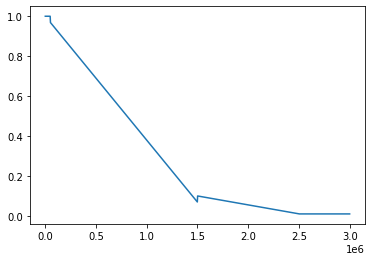

In [ ]:
e = np.linspace(0,3000000,1000)
l = []
for ee in e:
  l.append(calc_epsilon2(ee))
plt.plot(e,l)

In [ ]:
class CustomReward():
  def __init__(self):
    self.my_old_length  = 1
    self.geese_out_old = 0
 
 
  def get_reward(self,obs,terminal):
    reward = 0
    self.my_length = len(obs['geese'][obs['index']])
    if terminal == False:
      geese_out = len([i for i, x in enumerate(obs.geese) if x == []])
      if geese_out > self.geese_out_old:
        reward = reward + (geese_out-self.geese_out_old)*3
        self.geese_out_old = geese_out
      if self.my_length==self.my_old_length+1:
        reward = reward+0.1
      if self.my_length==self.my_old_length-1:
        reward = reward-0.1
      self.my_old_length = self.my_length
 
    if terminal == True:
      if obs['geese'][obs['index']] == []:
        reward = -10
      else:
        reward = +10
 
    return reward
 
  def reset(self):
    self.__init__()

In [ ]:
def correct_action(action,prev_action):
  if action == (prev_action+2)%4 and prev_action!=5:
    action = prev_action
  return (action)

In [ ]:
def plot_progress(data,f=200):
  if type(data)==str:
    d = pd.read_csv(data)
  else:
    d = data
  k = []
  for i in range(0,len(d),f):
    k.append(np.mean(d[i:i+f]))
  plt.plot(k)
  plt.grid()
  plt.show()
  

In [ ]:
agent_kag1 = Agent_kag()
agent_kag2 = Agent_kag()
agent_kag3 = Agent_kag()
agent_kag4 = Agent_kag()

env = make("hungry_geese", debug=False)
save_dirr = '/content/drive/My Drive/ML/RL/hungry_geese/'
trainer = env.train([None,  agent_kag1.play,  agent_kag2.play,  agent_kag3.play])
conf = env.configuration
 
WEIGHT_SAVE_FREQ = 5000
MAX_EPISODE_LENGTH = 100000
UPDATE_FREQ = 4
TARGET_UPDATE_FREQ = 50000
MIN_REPLAY_BUFFER_SIZE = 50000
PER = True
PER_ALPHA = 0.7
HISTORY_LENGTH = 2
REPLAY_BUFFER_SIZE = 400000
MINIBATCH_SIZE = 32
LEARNING_RATE = 0.00005
GAMMA = 0.99
NUM_EPOCHS = 500000
OPONENT_UPDATE = 500000

In [ ]:
rewards_list = []
loss_list = []
ep_steps_list = []

In [ ]:
from numpy import savetxt
 
frame_number = 2500000
rewards_list = []
loss_list = []
ep_steps_list = []
n_actions = 4
rows = conf['rows']
columns = conf['columns']
action_list = np.zeros((4))
if PER :
  replay_buffer = PrioritizedReplayBuffer(size = REPLAY_BUFFER_SIZE, minibatch_size = MINIBATCH_SIZE, alpha = PER_ALPHA)
else :
  replay_buffer = ReplayBuffer(REPLAY_BUFFER_SIZE,MINIBATCH_SIZE)

# model = build_Torus_q_network(n_actions=n_actions, learning_rate=LEARNING_RATE, input_shape=(7, 11, HISTORY_LENGTH*3), layers=12, filters=32)
# model_target = build_Torus_q_network(n_actions=n_actions, learning_rate=LEARNING_RATE, input_shape=(7, 11, HISTORY_LENGTH*3), layers=12, filters=32)
# #model1.load_weights(save_dirr)
# #model2.load_weights(save_dirr)
model = tf.keras.models.load_model(save_dirr +'weights_hungry_geese_10.h5')
model_target = tf.keras.models.load_model(save_dirr +'weights_hungry_geese_10.h5')
agent = Agent(model,model_target,n_actions,GAMMA,MINIBATCH_SIZE)
agent1 = Agent(model,model_target,n_actions,GAMMA,MINIBATCH_SIZE)
agent2 = Agent(model,model_target,n_actions,GAMMA,MINIBATCH_SIZE)
agent3 = Agent(model,model_target,n_actions,GAMMA,MINIBATCH_SIZE)
t1 = time.time()
My_reward = CustomReward()

agent_kag1 = Agent_kag()
env = make("hungry_geese", debug=False)
agent1.model.set_weights(agent.model.get_weights())
agent1.model_target.set_weights(agent.model.get_weights())
agent2.model.set_weights(agent.model.get_weights())
agent2.model_target.set_weights(agent.model.get_weights())
agent3.model.set_weights(agent.model.get_weights())
agent3.model_target.set_weights(agent.model.get_weights())
trainer = env.train([None,  agent1.play_agent,  agent2.play_agent, agent_kag1.play])

In [ ]:
replay_buffer.load(save_dirr)

In [ ]:
a = list([0,1])
a.append(3)
a

[0, 1, 3]

In [ ]:
ep_steps_list = pd.read_csv('/content/drive/My Drive/ML/RL/hungry_geese_ep_steps_list_10.csv')
rewards_list = pd.read_csv('/content/drive/My Drive/ML/RL/hungry_geese_rewards_list_10.csv')

In [ ]:
ep_steps_list = list(np.array(ep_steps_list).squeeze())
rewards_list = list(np.array(rewards_list).squeeze())

In [ ]:
len(rewards_list)

44999

saved
[0. 0. 0. 0.]


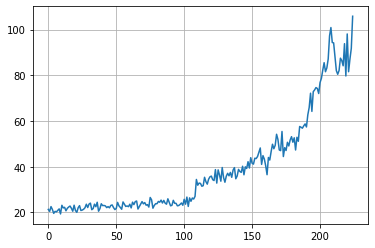

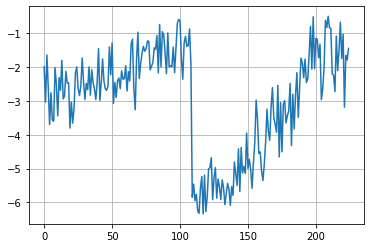

Game number: 045000          Frame number: 02500070  Average reward: -1.5  Time taken: 32.5s  Episode steps: 105.7
Game number: 045200          Frame number: 02525195  Average reward: 3.7  Time taken: 373.3s  Episode steps: 125.6
Game number: 045400          Frame number: 02551581  Average reward: 5.5  Time taken: 414.9s  Episode steps: 131.9
Game number: 045600          Frame number: 02571230  Average reward: 2.3  Time taken: 634.5s  Episode steps: 98.2
Game number: 045800          Frame number: 02598064  Average reward: 4.6  Time taken: 886.8s  Episode steps: 134.2
Game number: 046000          Frame number: 02622675  Average reward: 3.2  Time taken: 812.4s  Episode steps: 123.1
Game number: 046200          Frame number: 02648090  Average reward: 2.9  Time taken: 842.5s  Episode steps: 127.1
Game number: 046400          Frame number: 02675484  Average reward: 4.5  Time taken: 909.1s  Episode steps: 137.0
Game number: 046600          Frame number: 02701583  Average reward: 3.9  Time ta

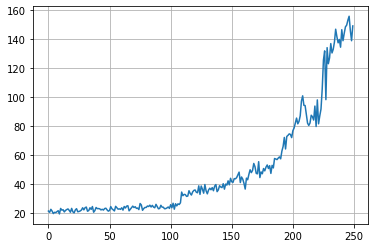

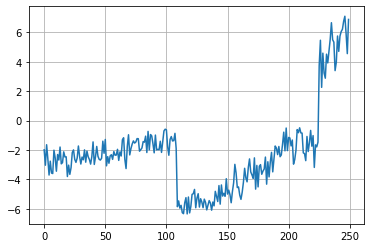

Game number: 050000          Frame number: 03189977  Average reward: 6.9  Time taken: 1007.0s  Episode steps: 148.6
Game number: 050200          Frame number: 03218712  Average reward: 6.0  Time taken: 976.0s  Episode steps: 143.7
Game number: 050400          Frame number: 03248367  Average reward: 5.6  Time taken: 1008.2s  Episode steps: 148.3
Game number: 050600          Frame number: 03278675  Average reward: 5.8  Time taken: 1013.6s  Episode steps: 151.5
Game number: 050800          Frame number: 03307254  Average reward: 6.3  Time taken: 948.7s  Episode steps: 142.9
Game number: 051000          Frame number: 03335308  Average reward: 4.9  Time taken: 938.2s  Episode steps: 140.3
Game number: 051200          Frame number: 03364819  Average reward: 5.7  Time taken: 982.3s  Episode steps: 147.6
Game number: 051400          Frame number: 03394152  Average reward: 6.3  Time taken: 993.4s  Episode steps: 146.7
Game number: 051600          Frame number: 03423158  Average reward: 7.2  Tim

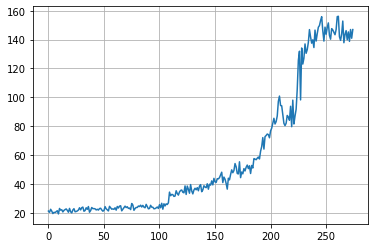

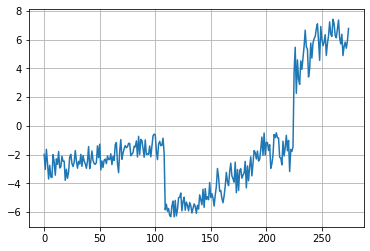

Game number: 055000          Frame number: 03916372  Average reward: 6.7  Time taken: 1013.3s  Episode steps: 146.3
Game number: 055200          Frame number: 03945707  Average reward: 5.6  Time taken: 993.3s  Episode steps: 146.7
Game number: 055400          Frame number: 03977148  Average reward: 8.2  Time taken: 1059.2s  Episode steps: 157.2
Game number: 055600          Frame number: 04008373  Average reward: 7.0  Time taken: 1079.1s  Episode steps: 156.1
Game number: 055800          Frame number: 04039451  Average reward: 7.1  Time taken: 1080.9s  Episode steps: 155.4
Game number: 056000          Frame number: 04071164  Average reward: 7.1  Time taken: 1095.7s  Episode steps: 158.6
Game number: 056200          Frame number: 04102585  Average reward: 8.0  Time taken: 1072.0s  Episode steps: 157.1
Game number: 056400          Frame number: 04133020  Average reward: 7.3  Time taken: 1034.3s  Episode steps: 152.2
Game number: 056600          Frame number: 04162945  Average reward: 6.4 

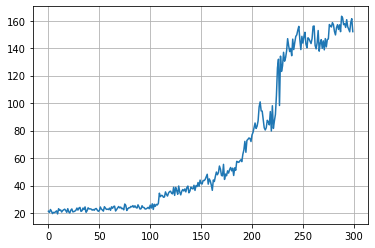

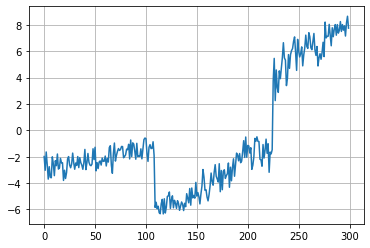

Game number: 060000          Frame number: 04695779  Average reward: 7.8  Time taken: 1078.2s  Episode steps: 152.3


KeyboardInterrupt: ignored

In [ ]:
for epochs in range(NUM_EPOCHS):
    start_time = time.time()
    obs = trainer.reset()
    state = np.zeros((rows, columns, HISTORY_LENGTH*3))
    new_frame = transform_observation2(obs,conf)
    state = np.append(state[:, :, 3:], new_frame, axis=2)
    episode_reward_sum = 0
    prev_action = 5
    ep_steps=0

 
    if epochs % WEIGHT_SAVE_FREQ == 0 and len(rewards_list)>1:
      savetxt('/content/drive/My Drive/ML/RL/hungry_geese_rewards_list_10_1.csv', np.asarray(rewards_list), delimiter=',')
      savetxt('/content/drive/My Drive/ML/RL/hungry_geese_ep_steps_list_10_1.csv', np.asarray(ep_steps_list), delimiter=',')
      agent.model.save(save_dirr+'weights_hungry_geese_10_1.h5')
      replay_buffer.save(save_dirr)
      print('saved')
      print(action_list)
      plot_progress(ep_steps_list,f=200)
      plot_progress(rewards_list,f=200)
 
    for _ in range(MAX_EPISODE_LENGTH):
        ep_steps+= 1
        action = agent.get_action(calc_epsilon2(frame_number), state,prev_action)
        action_list[action] = action_list[action] +1
        obs, reward, terminal, info = trainer.step(action_num_to_name(correct_action(action,prev_action)))
        reward = My_reward.get_reward(obs,terminal)
        new_frame = transform_observation2(obs,conf)
        new_state = np.append(state[:, :, 3:], new_frame, axis=2)
 
        frame_number += 1
        episode_reward_sum += reward
        replay_buffer.append( state, action, reward, terminal, new_state)
 
        state = new_state
        prev_action = correct_action(action,prev_action)
 
        # Update agent
        if frame_number % UPDATE_FREQ == 0 and replay_buffer.sizee() > MIN_REPLAY_BUFFER_SIZE:
          if PER:
            experiences,weights = replay_buffer.sample(calc_beta(frame_number))
          else :
            experiences = replay_buffer.sample()
            weights = None
          errors = agent.learn(experiences,PER,weights)
          if PER:
            replay_buffer.update_priorities(errors)
 
 
        # Update target network
        if frame_number % TARGET_UPDATE_FREQ == 0 and frame_number > MIN_REPLAY_BUFFER_SIZE:
            agent.model_target.set_weights(agent.model.get_weights())
        
        if frame_number%OPONENT_UPDATE==0 :
          agent_kag1 = Agent_kag()
          env = make("hungry_geese", debug=False)
          agent1.model.set_weights(agent.model.get_weights())
          agent1.model_target.set_weights(agent.model.get_weights())
          agent2.model.set_weights(agent.model.get_weights())
          agent2.model_target.set_weights(agent.model.get_weights())
          agent3.model.set_weights(agent.model.get_weights())
          agent3.model_target.set_weights(agent.model.get_weights())
          trainer = env.train([None,  agent1.play_agent,  agent2.play_agent, agent_kag1.play])
          conf = env.configuration
 
#       # Break the loop when the game is over
        if terminal:
            My_reward.reset()
            break

    rewards_list.append(episode_reward_sum)
    ep_steps_list.append(ep_steps)
      # Output the progress every 10 games
    if len(rewards_list) % 200 == 0: 
 
        print(f'Game number: {str(len(rewards_list)).zfill(6)}  \
        Frame number: {str(frame_number).zfill(8)}  Average reward: {np.mean(rewards_list[-200:]):0.1f}  Time taken: {(time.time() - t1):.1f}s  Episode steps: {np.mean(ep_steps_list[-200:]):0.1f}'  )
        t1 = time.time()
        

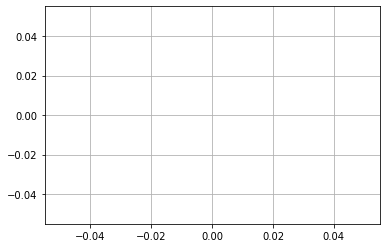

In [ ]:
plot_progress(ep_steps_list.)

In [ ]:
import pandas as pd
d = pd.read_csv('/content/drive/My Drive/ML/RL/hungry_geese_rewards_list_4.csv')
# d2 = pd.read_csv('/content/drive/My Drive/ML/RL/hungry_geese_rewards_list_inception_t3_rewardout_lr10_2.csv')
# d = d.append(d2)
# d= ep_steps_list
k = []
f = 200
for i in range(0,len(d),f):
  k.append(np.mean(d[i:i+f]))
plt.plot(k)

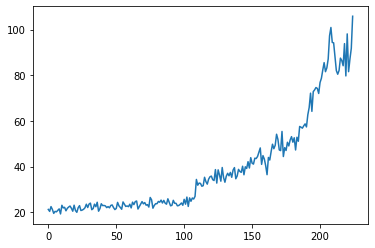

In [ ]:
import pandas as pd
d = ep_steps_list
d.append(100)
# d2 = pd.read_csv('/content/drive/My Drive/ML/RL/hungry_geese_rewards_list_inception_t3_rewardout_lr10_2.csv')
# d = d.append(d2)
# d= ep_steps_list
k = []
f = 200
for i in range(0,len(d),f):
  k.append(np.mean(d[i:i+f]))
plt.plot(k)

In [ ]:
d

In [ ]:
save_dirr = '/content/drive/My Drive/ML/RL/hungry_geese/'
model1 = tf.keras.models.load_model(save_dirr +'weights_hungry_geese_10_1.h5')
model2 = tf.keras.models.load_model(save_dirr +'weights_hungry_geese_10_1.h5')
agent = Agent(model1,model1,4,GAMMA,MINIBATCH_SIZE)
agent1 = Agent(model2,model2,4,GAMMA,MINIBATCH_SIZE)
agent2 = Agent(model2,model2,4,GAMMA,MINIBATCH_SIZE)
agent3 = Agent(model2,model2,4,GAMMA,MINIBATCH_SIZE)

env = make("hungry_geese", debug=True)
env.run([agent1.play_agent,  agent2.play_agent,agent3.play_agent,agent_kag1.play])
env.render(mode="ipython",)

Goose Collision: EAST
Body Hit: (3, <Action.WEST: 4>, 47, [48, 37, 36, 47, 58, 59, 60, 61])


0
False


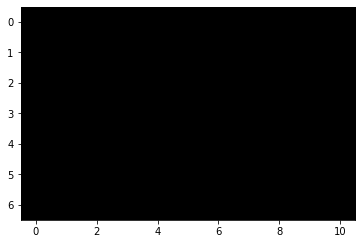

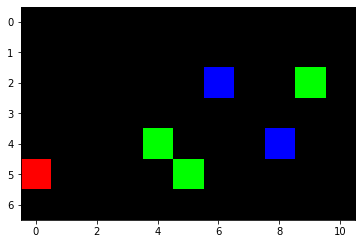

0.0
False


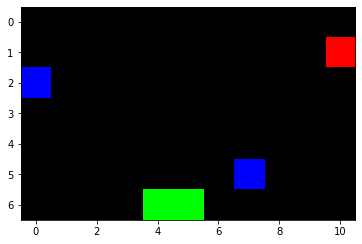

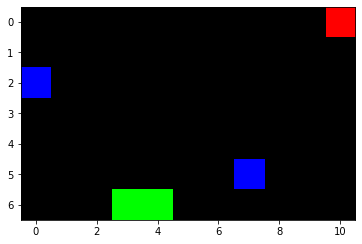

0
False


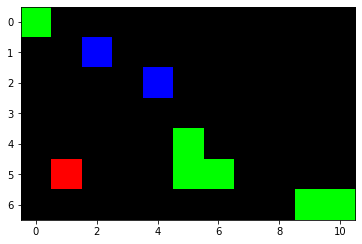

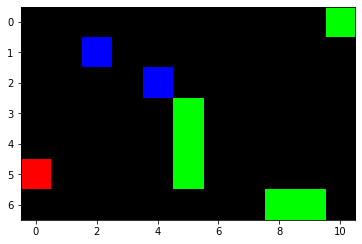

0.0
False


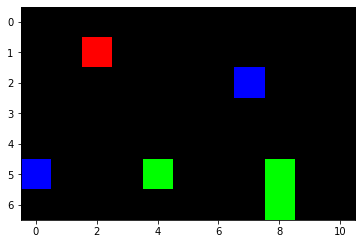

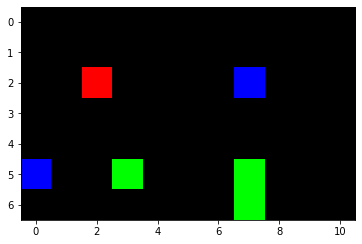

0.0
False


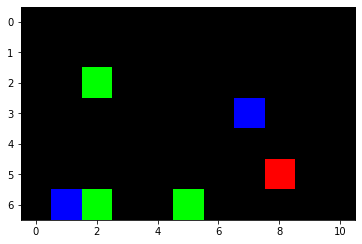

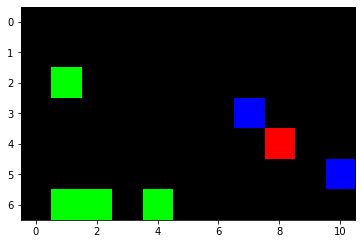

0
False


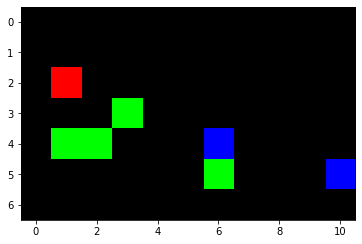

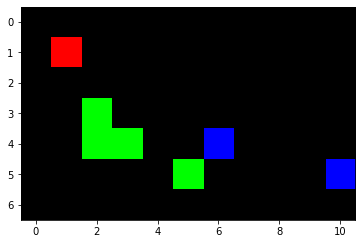

0
False


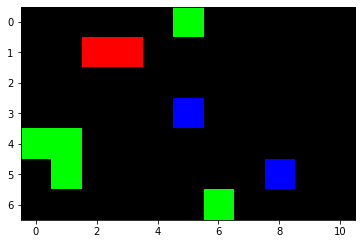

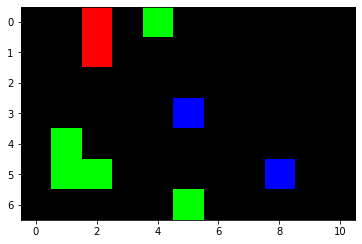

0.0
False


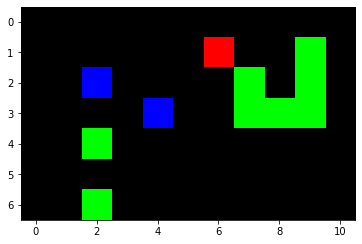

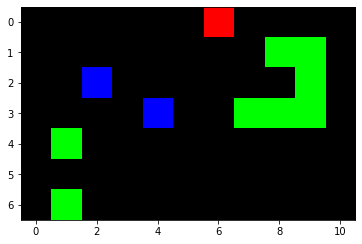

0.0
False


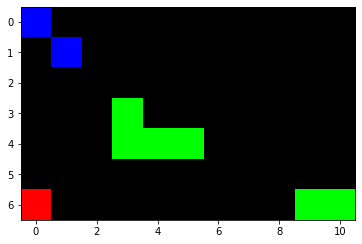

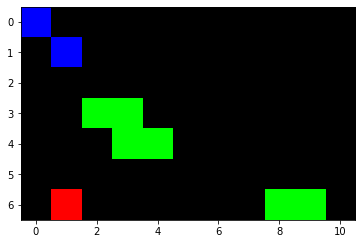

0
False


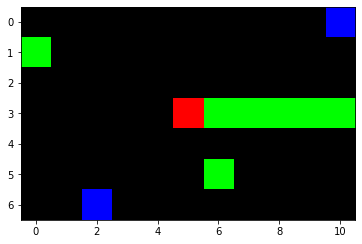

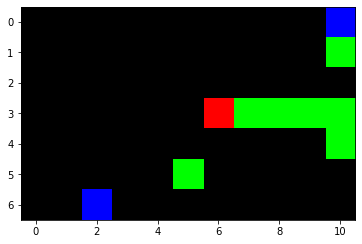

0.0
False


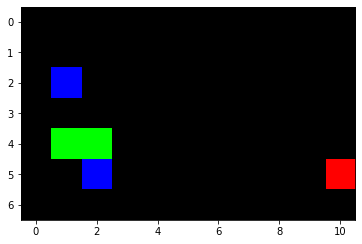

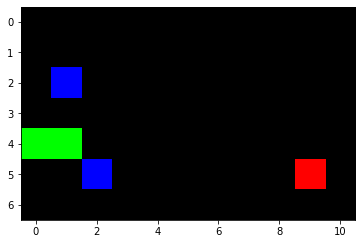

0.0
False


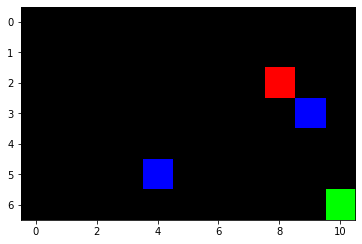

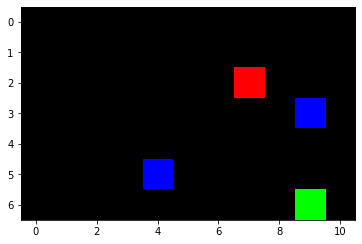

0
False


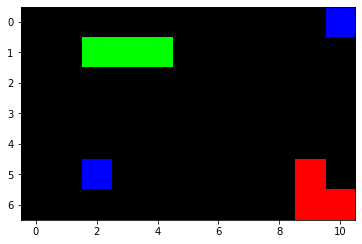

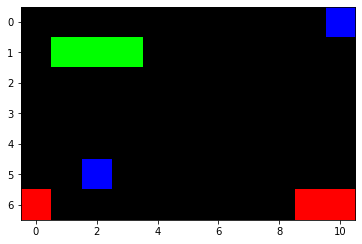

-10.0
True


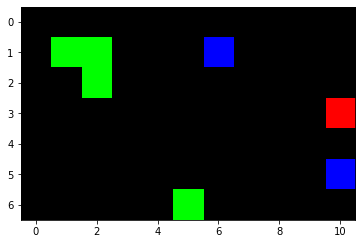

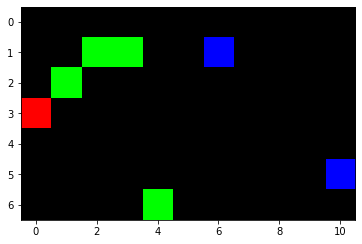

0
False


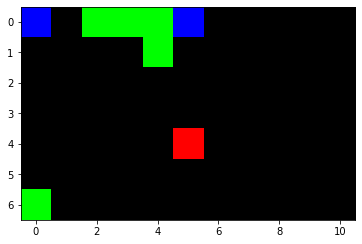

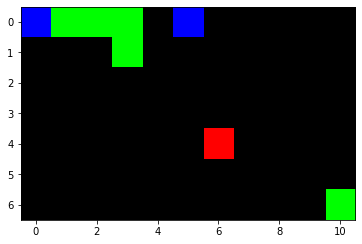

0
False


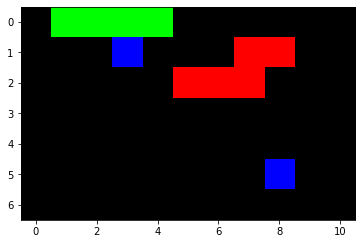

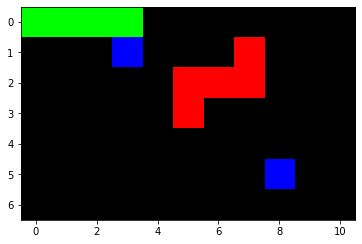

0.0
False


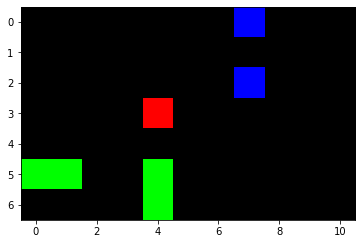

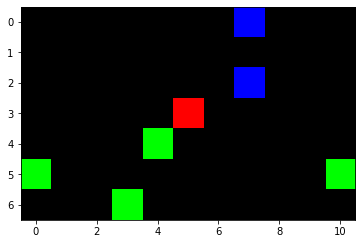

0
False


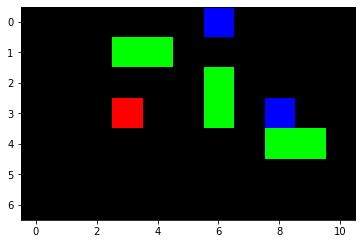

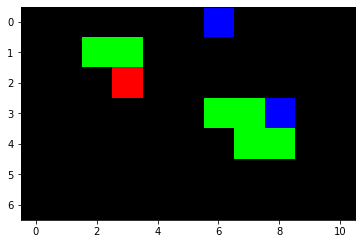

0.0
False


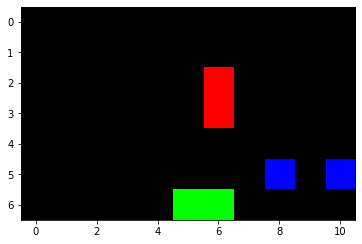

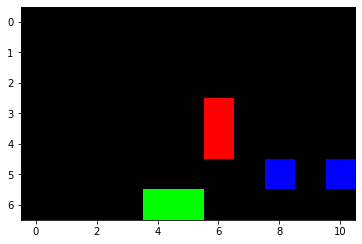

0.0
False


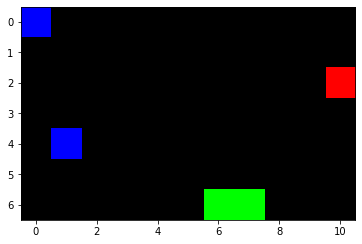

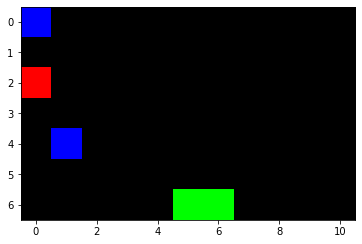

0
False


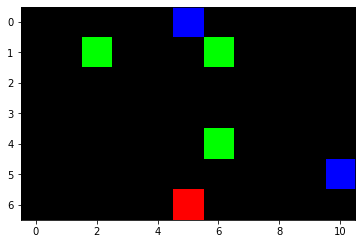

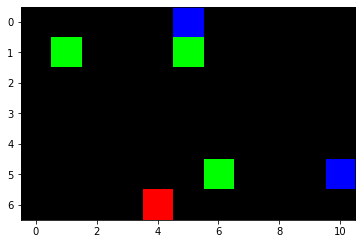

0.0
False


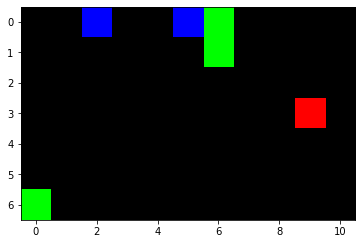

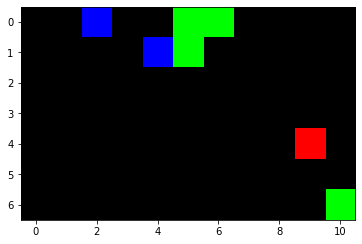

0.0
False


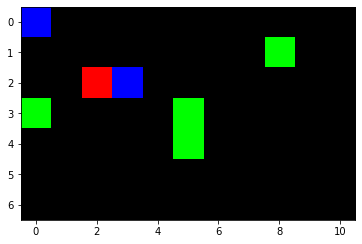

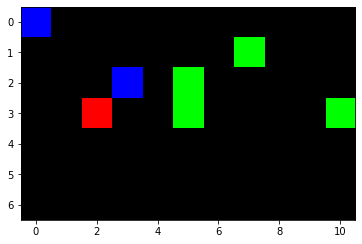

0.0
False


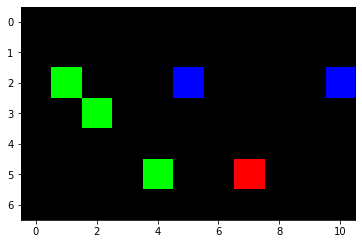

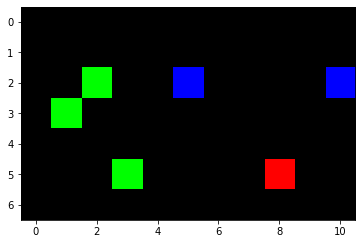

0.0
False


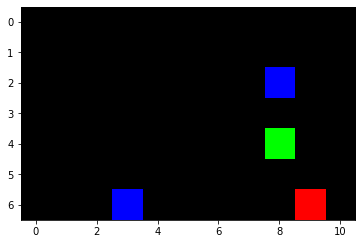

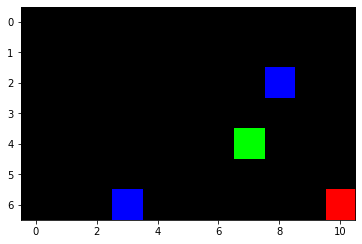

0
False


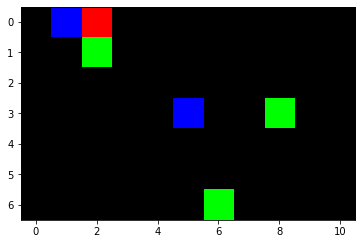

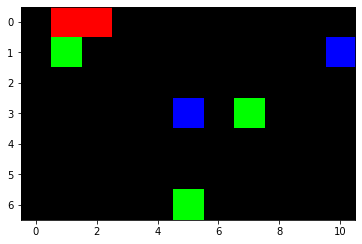

0
False


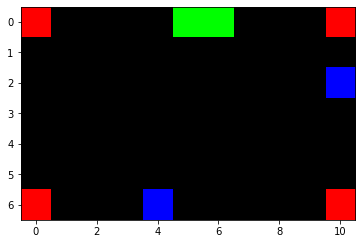

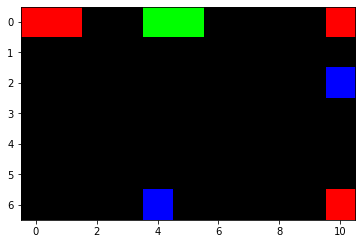

-10.0
True


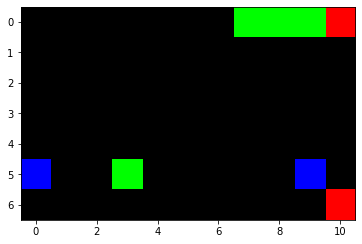

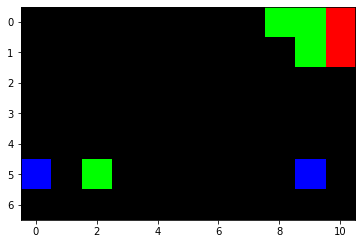

0.0
False


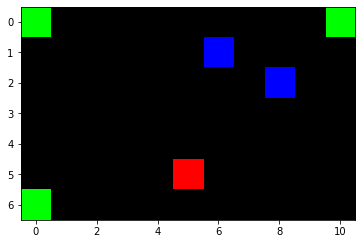

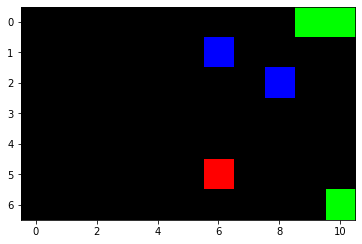

0
False


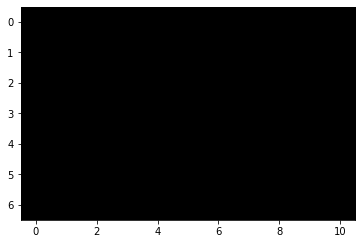

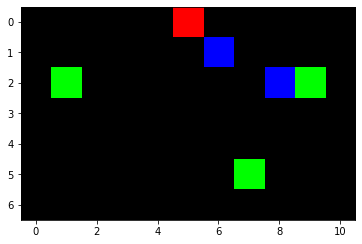

0
False


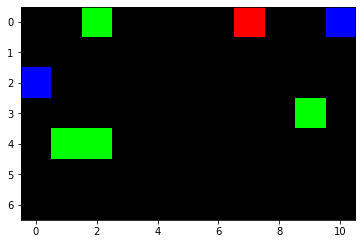

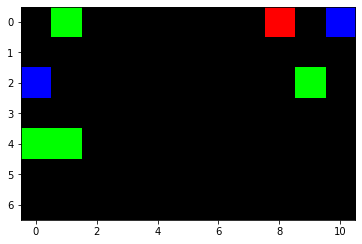

0
False


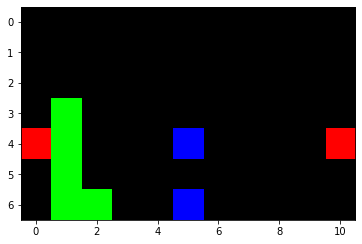

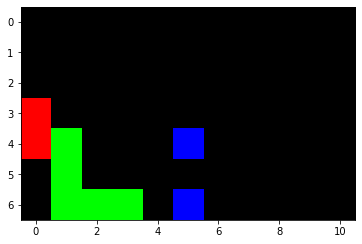

0
False


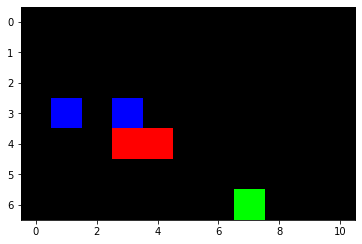

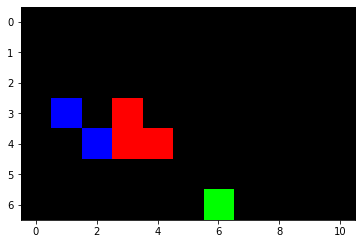

0.0
False


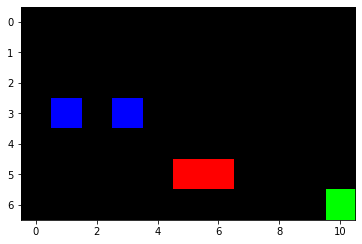

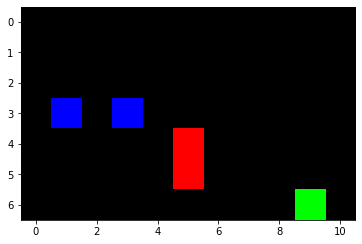

0
False


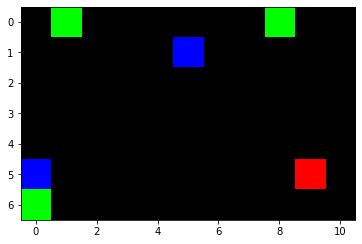

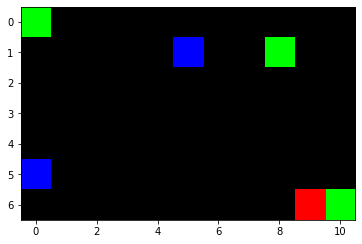

0.0
False


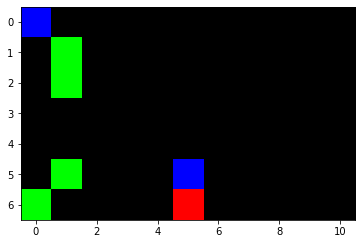

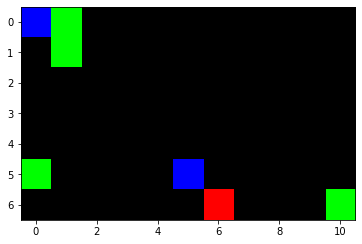

0.0
False


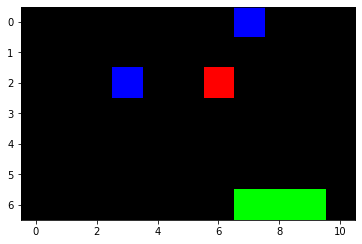

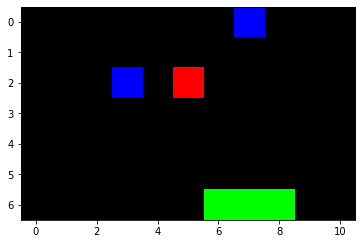

0.0
False


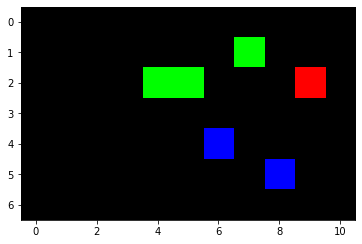

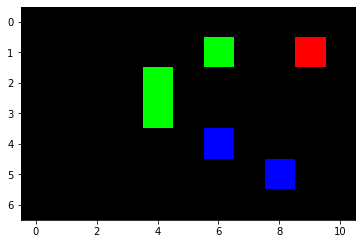

0.0
False


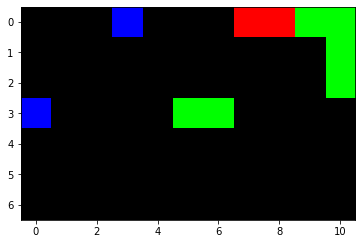

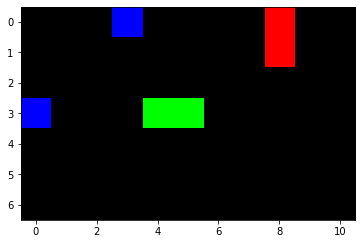

0.0
False


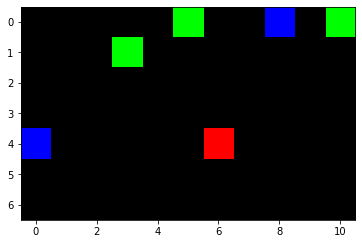

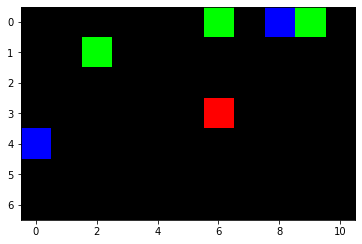

-10
True


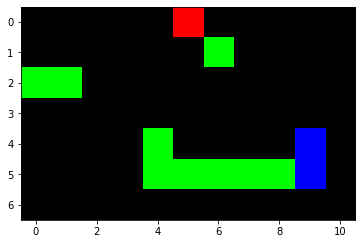

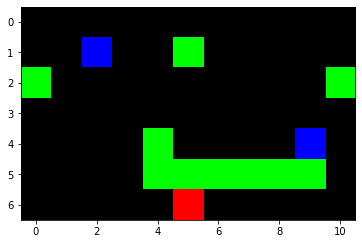

0.0
False


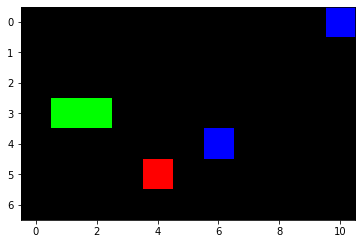

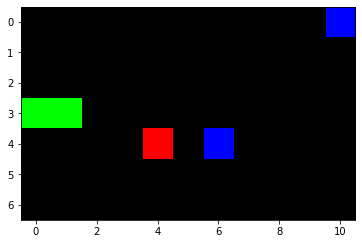

0.0
False


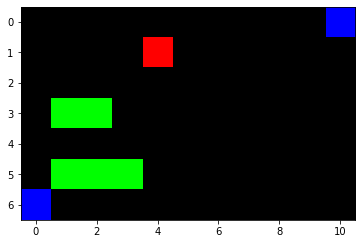

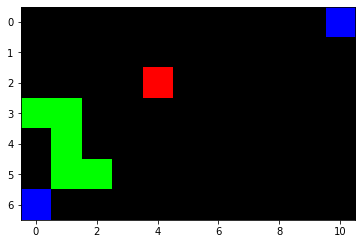

0
False


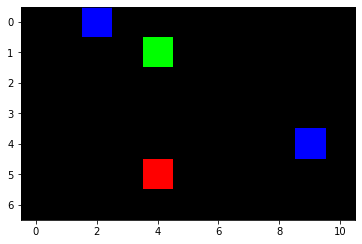

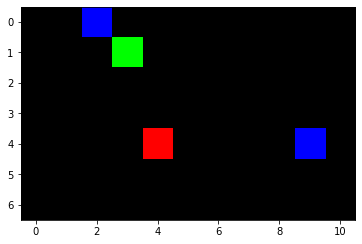

0
False


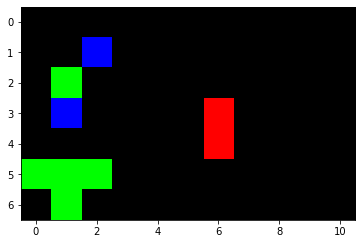

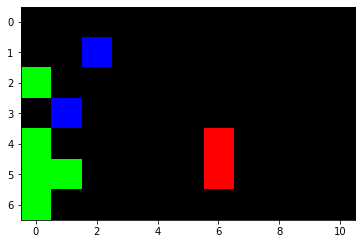

-10.0
True


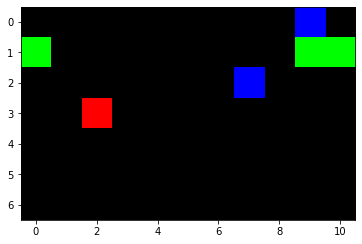

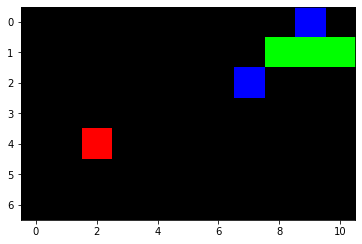

0.0
False


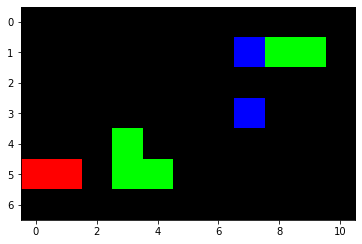

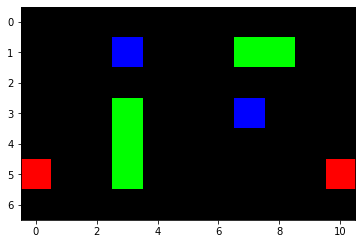

0
False


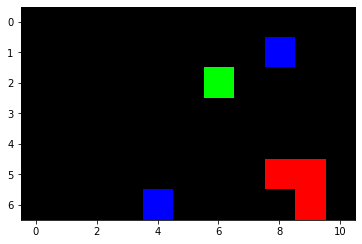

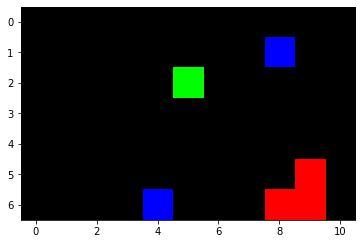

0.0
False


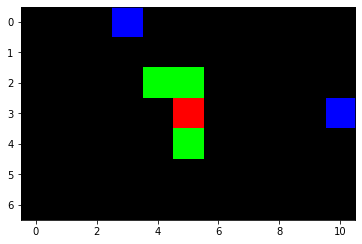

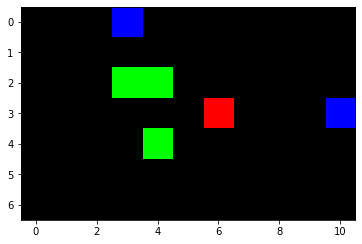

0.0
False


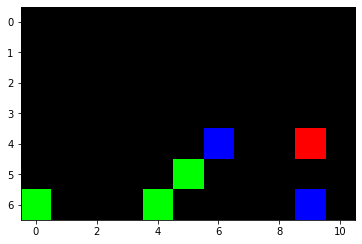

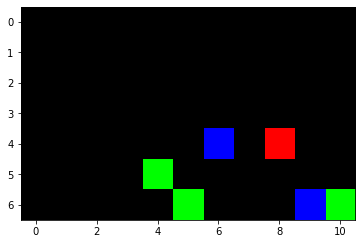

0.0
False


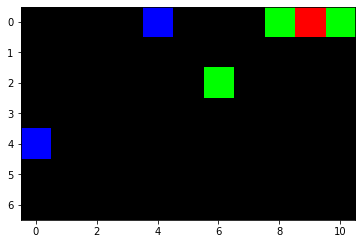

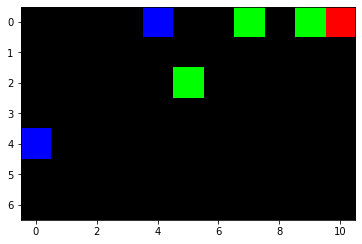

0
False


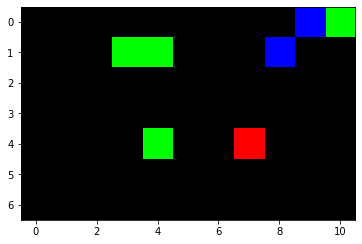

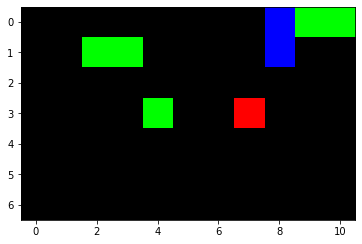

-10
True


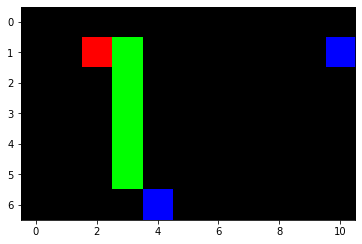

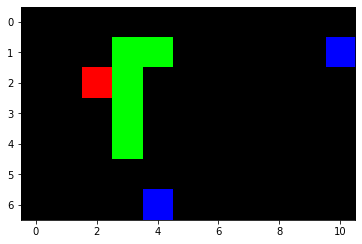

0.0
False


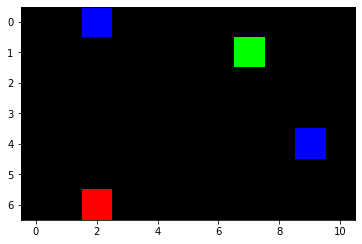

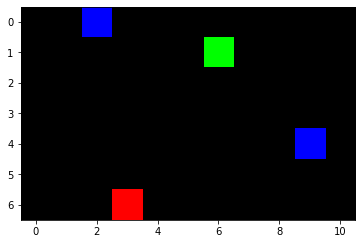

0.0
False


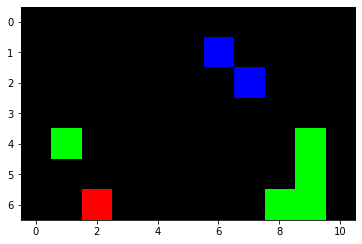

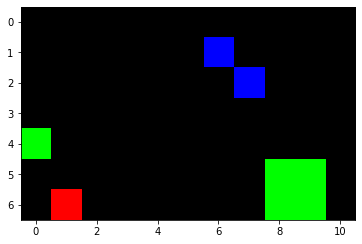

0.0
False


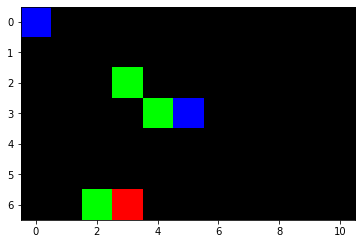

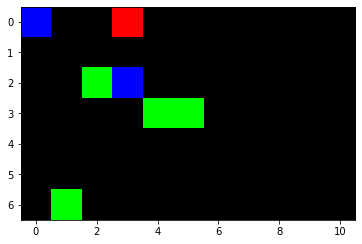

0.0
False


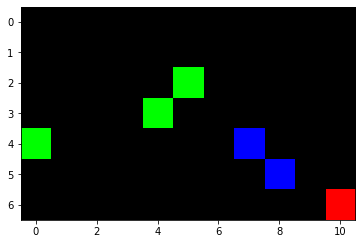

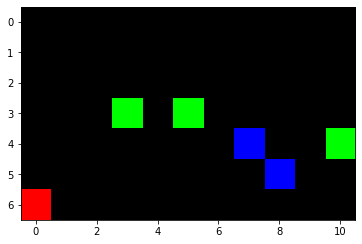

0.0
False


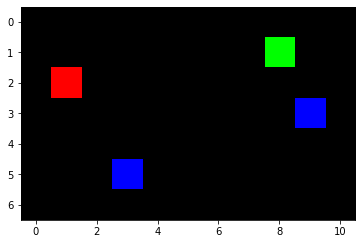

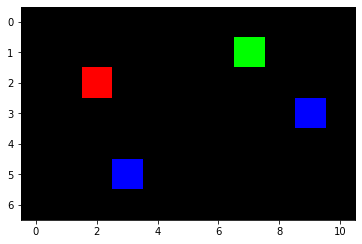

0
False


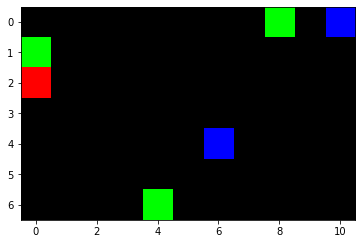

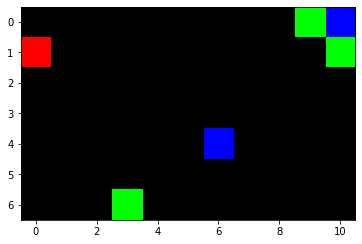

-10.0
True


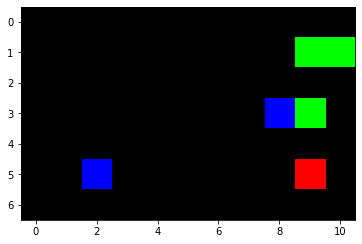

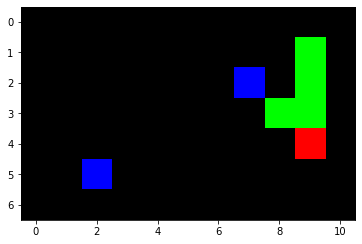

0
False


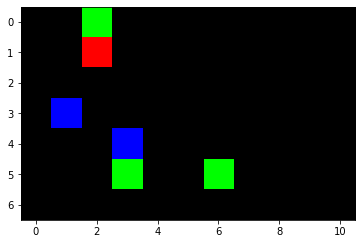

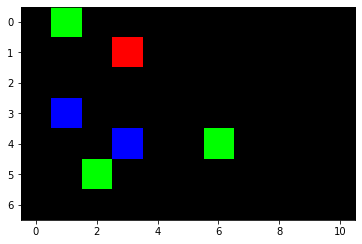

0
False


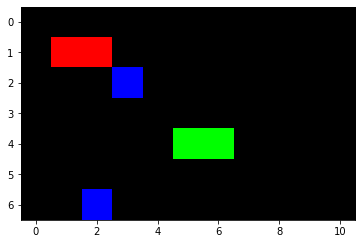

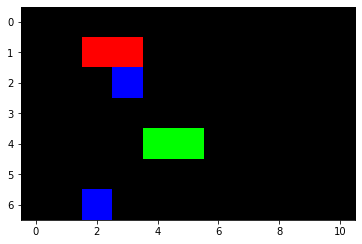

0
False


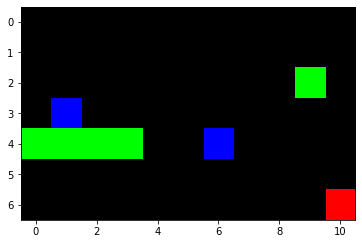

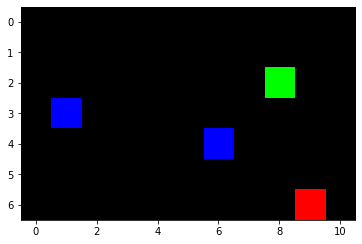

0.0
False


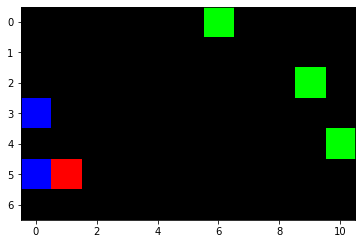

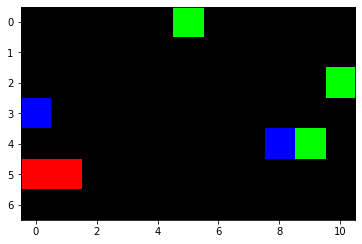

0.0
False


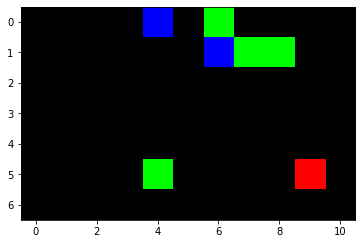

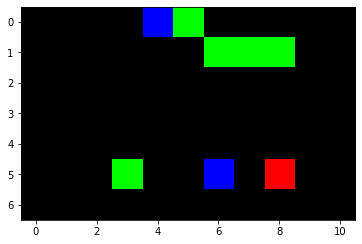

0
False


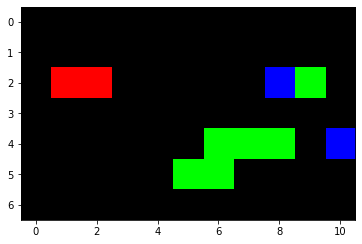

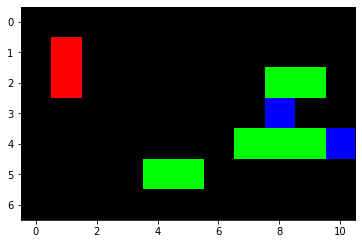

0.0
False


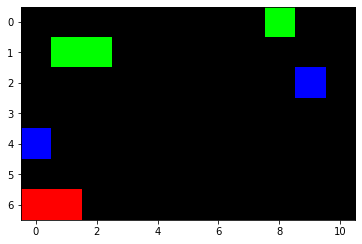

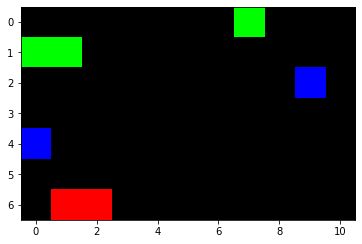

0.0
False


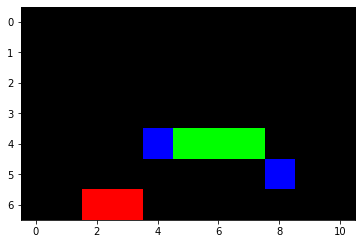

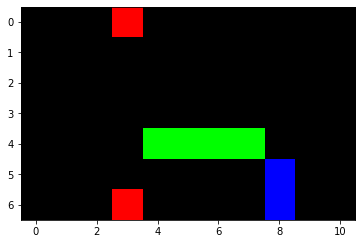

0.0
False


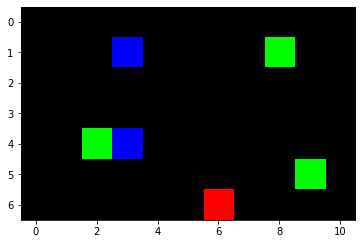

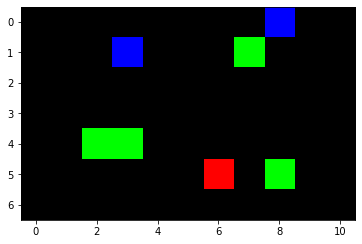

0
False


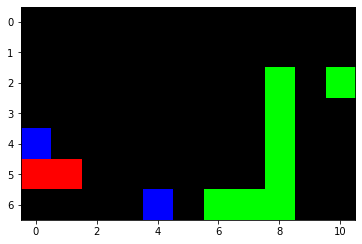

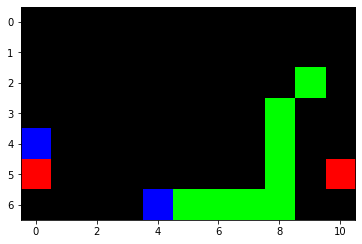

0.0
False


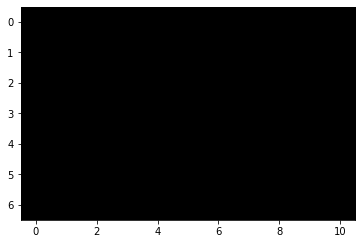

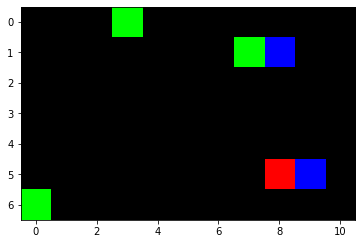

0.0
False


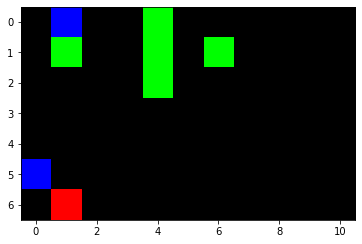

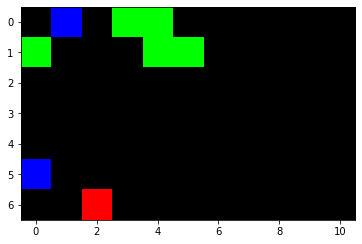

0.0
False


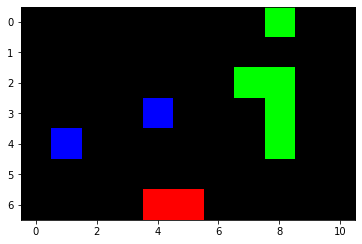

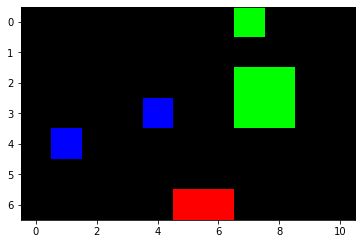

0.0
False


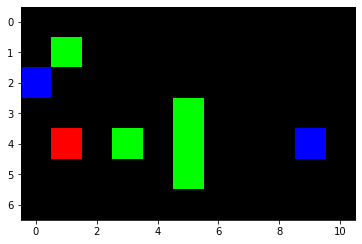

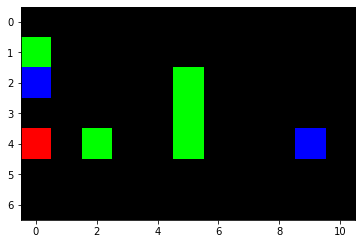

0.0
False


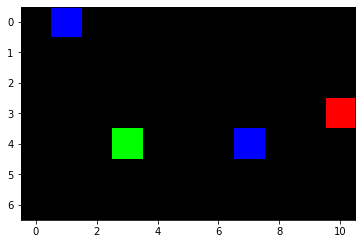

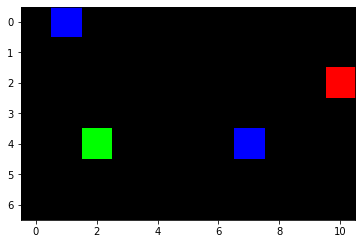

0.0
False


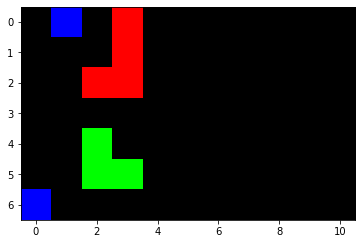

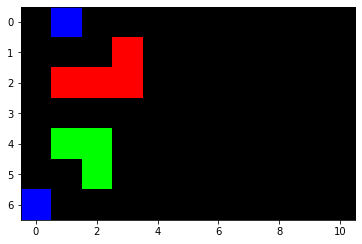

0.0
False


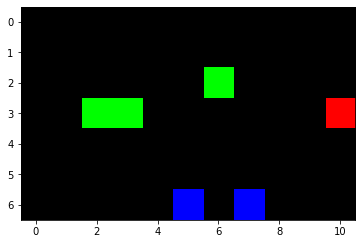

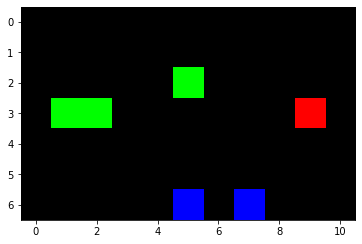

-10
True


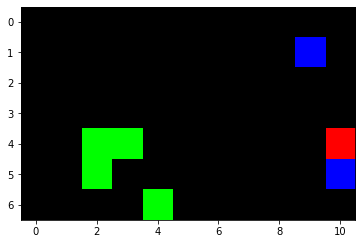

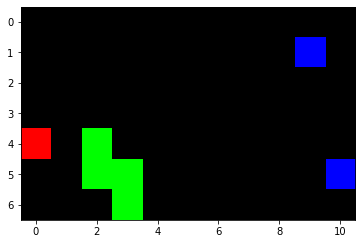

0.0
False


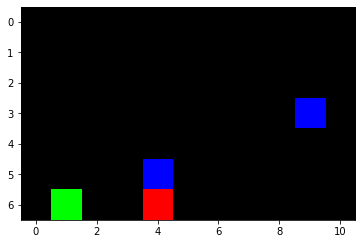

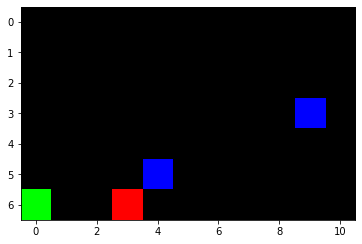

0
False


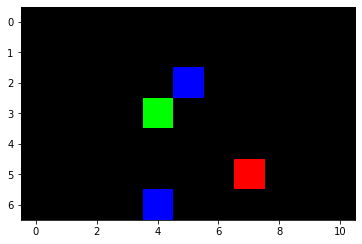

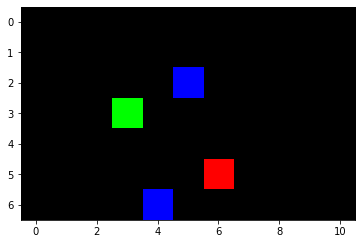

0.0
False


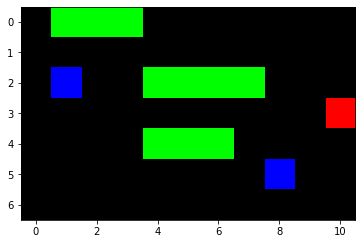

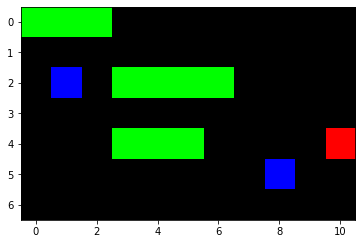

0.0
False


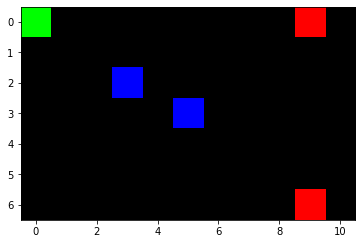

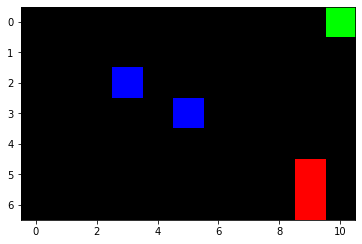

0
False


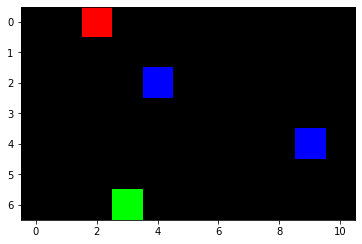

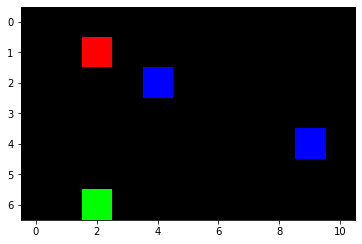

0
False


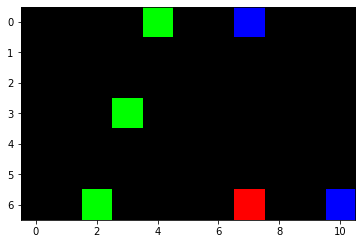

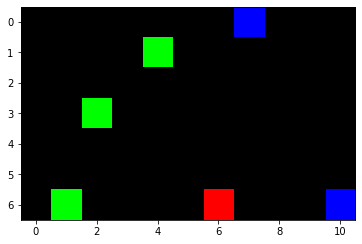

0.0
False


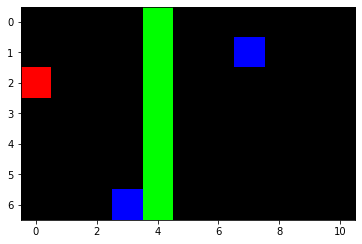

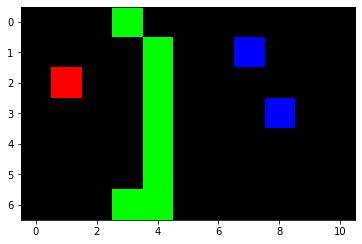

-10.0
True


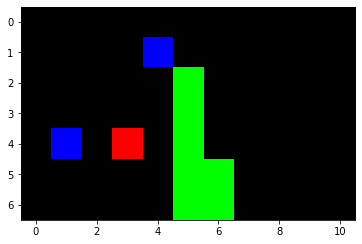

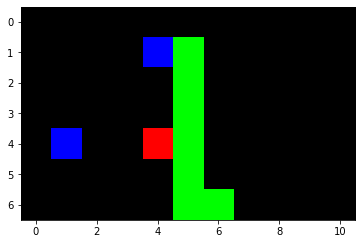

0.0
False


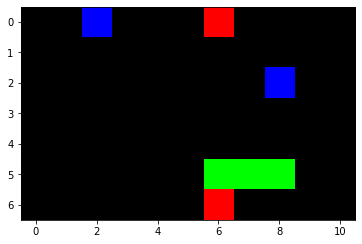

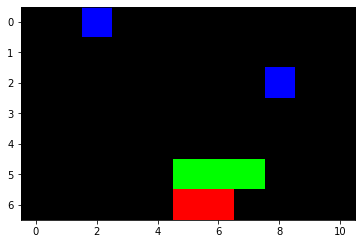

0.0
False


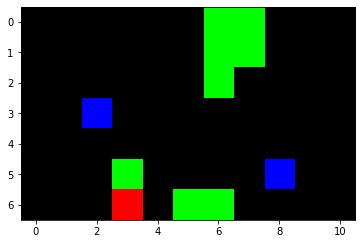

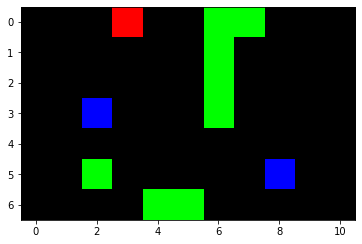

0.0
False


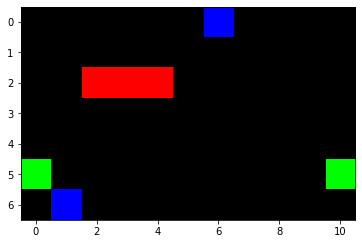

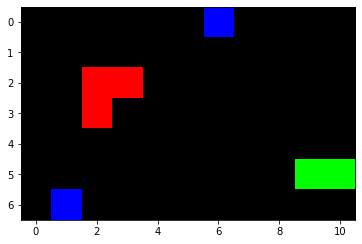

0.0
False


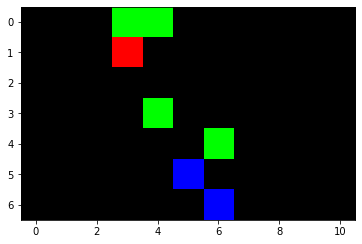

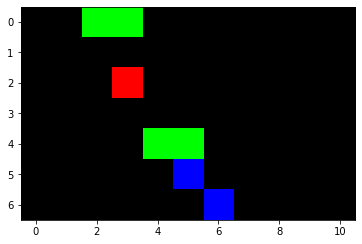

0
False


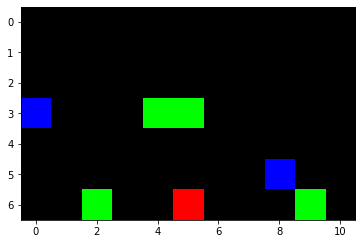

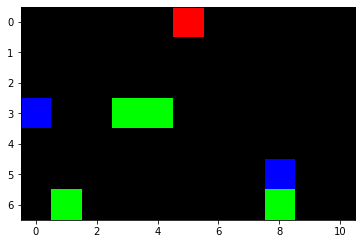

0
False


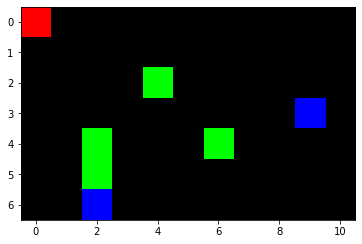

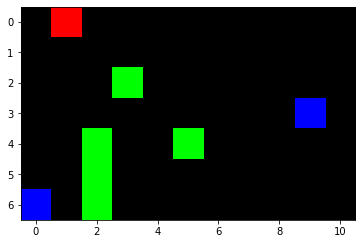

0.0
False


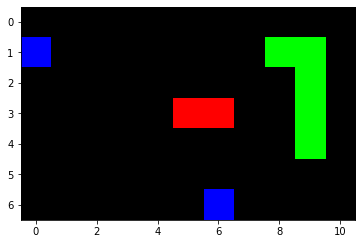

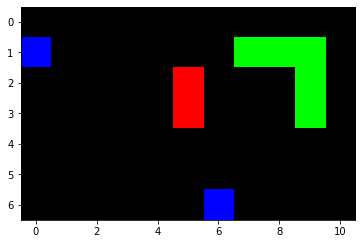

0
False


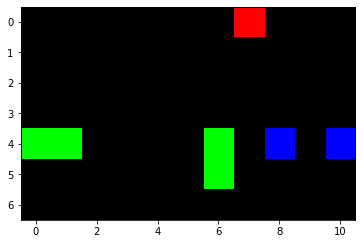

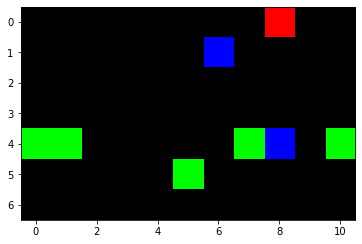

0.0
False


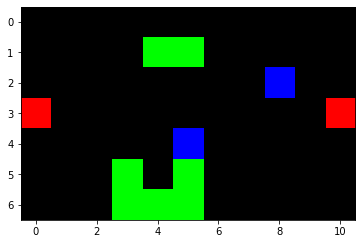

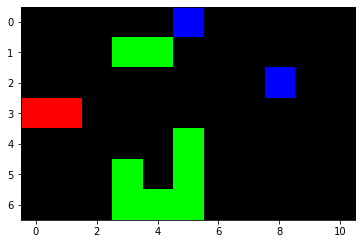

0.1
False


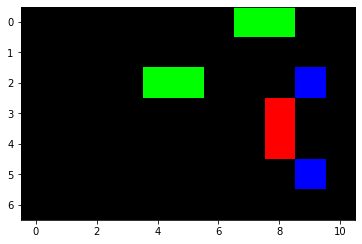

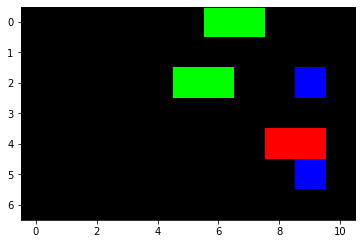

0
False


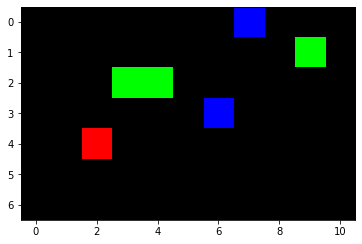

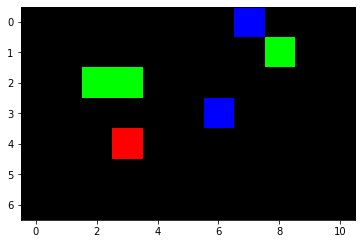

0.0
False


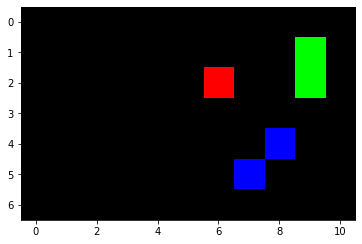

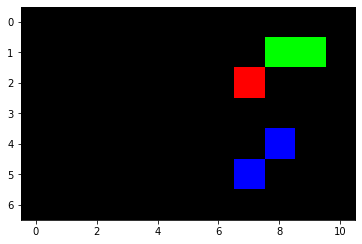

0
False


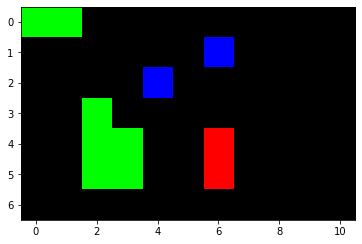

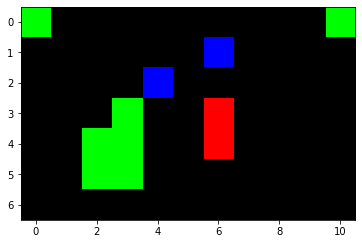

0.0
False


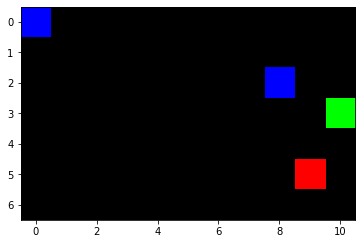

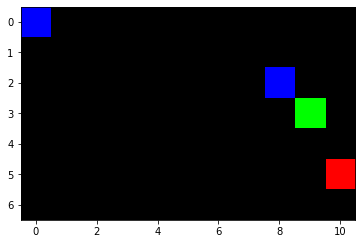

In [ ]:
for _ in range(100):
  experiences = replay_buffer.sample()

  states, actions, rewardss, terminal_flags, new_states = map(list, zip(*experiences))

  states = np.array(states)
  actions = np.array(actions)
  rewardss = np.array(rewardss)
  terminal_flags = np.array(terminal_flags)
  new_states = np.array(new_states)

  print(rewardss[0])
  print(terminal_flags[0])
  plt.imshow(states[0,:,:,:3])
  plt.show()
  plt.imshow(states[0,:,:,3:])
  plt.show()

0
[[67], [71], [61], [54]]


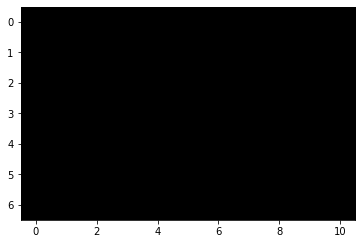

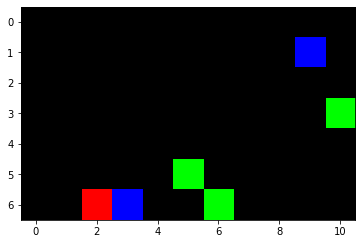

0
[[66], [70], [62], [65]]


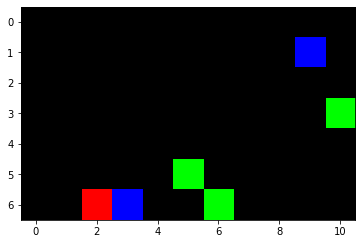

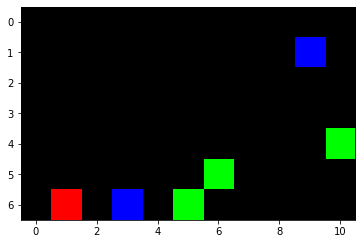

-10
[[], [69, 70], [73], []]


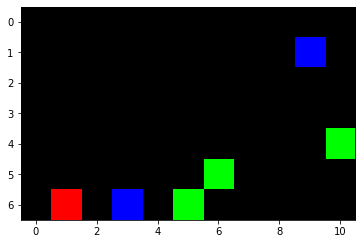

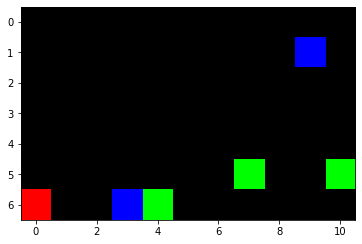

-10


In [ ]:
from kaggle_environments import make
 
env = make("hungry_geese", debug=False)
state = np.zeros((7, 11, 6))
trainer = env.train([None,  agent_kag1.play,  agent_kag2.play,  agent_kag3.play])
 
obs = trainer.reset()
new_frame = transform_observation2(obs,conf)
state = np.append(state[:, :, 3:], new_frame, axis=2)
rewards = 0
My_reward = CustomReward()
for i in range(1000):
    action = agent.play_agent(obs,conf) # Action for the agent being trained.
    obs, reward, done, info = trainer.step(action)
    reward = My_reward.get_reward(obs,done)
    new_frame = transform_observation2(obs,conf)
    new_state = np.append(state[:, :, 3:], new_frame, axis=2)
    rewards = rewards+reward
    print(reward)
    print(obs.geese)
    # # print(done)
    # # print(obs)
    plt.imshow(state[:,:,:3])
    plt.show()
    plt.imshow(state[:,:,3:])
    plt.show()

    state = new_state
    if done:
        obs = trainer.reset()
        print(rewards)
        break
        rewards = 0
        My_reward.reset()

In [ ]:
env = make("hungry_geese", debug=False)
trainer = env.train([None,  agent_kag1.play,  agent_kag2.play,  agent_kag3.play])
 
obs = trainer.reset()
state = np.zeros((7, 11, 6))
new_frame = transform_observation2(obs,conf)
state = np.append(state[:, :, 3:], new_frame, axis=2)

In [ ]:
obs

{'food': [55, 51],
 'geese': [[32], [65], [11], [13]],
 'index': 0,
 'remainingOverageTime': 60,
 'step': 0}

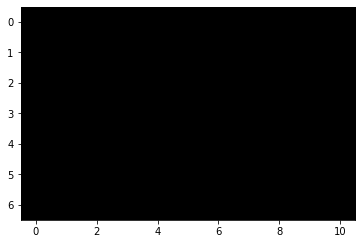

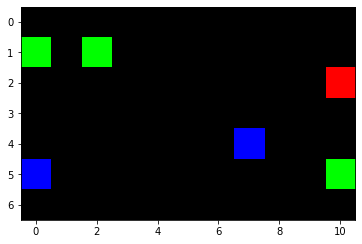

In [ ]:
plt.imshow(state[:,:,:3])
plt.show()
plt.imshow(state[:,:,3:])
plt.show()

In [ ]:
state.shape

(7, 11, 6)

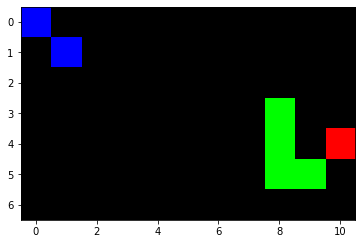

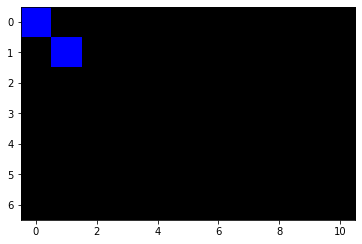

In [ ]:
plt.imshow(state[:,:,:3])
plt.show()
plt.imshow(state[:,:,3:])
plt.show()

In [ ]:
%%writefile model.py
import cv2
import numpy as np
import gym
import random
import time
import sys
import os
 
import tensorflow as tf
from tensorflow.keras.initializers import VarianceScaling
from tensorflow.keras.layers import (Add, Conv2D, Dense, Flatten, Input,
                                     Lambda, Subtract,MaxPool2D,Concatenate,BatchNormalization,Activation,GlobalAveragePooling2D)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, RMSprop
 
from kaggle_environments import make
from kaggle_environments.envs.hungry_geese.hungry_geese import Observation, Configuration, Action, row_col
 
import matplotlib.pyplot as plt


def transform_observation2(obs,conf):
    rows = conf['rows']
    columns = conf['columns']
    line_me = np.zeros((rows*columns))
    line_oponents = np.zeros((rows*columns))
    line_food = np.zeros((rows*columns))
    index = obs['index']
    for i in range(0,len(obs['geese'])):
      if i!=index:
        line_oponents[obs['geese'][i]] = 1
    line_me[obs['geese'][index]] = 1
    line_food[obs['food']] = 1
    image1 = np.reshape(line_me,(rows,columns,1))
    image2 = np.reshape(line_oponents,(rows,columns,1))
    image3 = np.reshape(line_food,(rows,columns,1))
    image = np.concatenate((image1,image2,image3),axis = 2)
    return image

def TorusConv2D(x, ch, kernel, padding="same", strides=1):
    x = Lambda(lambda x: tf.tile(x, (1,3,3,1)), 
               output_shape=lambda input_shape: (None, 3*input_shape[1], 3*input_shape[2], input_shape[3]))(x)
    
    x = Conv2D(ch, kernel, padding=padding, strides=strides)(x)
    
    x = Lambda(lambda x: x[:,int(x.shape[1]/3):2*int(x.shape[1]/3), int(x.shape[2]/3):2*int(x.shape[2]/3),:], 
               output_shape=lambda input_shape: (None, int(input_shape[1]/3), int(input_shape[2]/3), input_shape[3]))(x)
    return x
 
def conv_bn_relu(x0, ch, kernel, padding="same", strides=1, add=False):
    x = TorusConv2D(x0, ch, kernel, padding=padding, strides=strides)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    if add:
        x = Add()([x0, x])
    return x
 
def build_Torus_q_network(n_actions, learning_rate=0.00001, input_shape=(7, 11, 2), layers=12, filters=32):
    input = Input(input_shape)
    x = conv_bn_relu(input, filters, 3)
    
    # for i in range(layers):
    x = conv_bn_relu(x, 32, 3, add=True)
    x = conv_bn_relu(x, 32, 3, add=True)
    x = conv_bn_relu(x, 64, 3, add=False)
    x = conv_bn_relu(x, 64, 3, add=True)
    x = conv_bn_relu(x, 64, 3, add=True)
    x = conv_bn_relu(x, 128, 3, add=False)
    x = conv_bn_relu(x, 128, 3, add=True)
    x = conv_bn_relu(x, 128, 3, add=True)
    x = conv_bn_relu(x, 256, 3, add=False)
    
    
    x = GlobalAveragePooling2D()(x)
    x = Flatten()(x)
    x = Dense(512,activation='relu')(x)

    q_vals = Dense(n_actions)(x)   
    model = Model(input, q_vals)
    model.compile(Adam(learning_rate), loss=tf.keras.losses.Huber()) 
    
    return model


def correct_action(action,prev_action):
  if action == (prev_action+2)%4 and prev_action!=5:
    action = prev_action
  return (action)

class Agent():
  def __init__(self,model,model_target,n_actions,gamma,batch_size):
    self.model = model
    self.model_target = model_target
    self.n_actions = n_actions
    self.gamma = gamma
    self.batch_size = batch_size
    self.prev_state = 0
    self.prev_action=5
#     np.random.seed(0)
 
 
  def get_action(self, eps, state,prev_action, evaluation=False):
      if np.random.rand(1) < eps:
          action = np.random.randint(0, self.n_actions)
          # while action == (prev_action+2)%4 and prev_action!=5:
          #   action = np.random.randint(0, self.n_actions)
          return action
      q_vals = self.model.predict_on_batch(np.expand_dims(state,axis = 0))[0]
      # prevent choosing invalid action
      # if prev_action!=5 and evaluation==True:
      # q_vals[(prev_action+2)%4] = min(q_vals) - 1
      return q_vals.argmax() 
 
  def play_agent(self,obs,conf):
    if type(self.prev_state)==int:
        state = np.repeat(transform_observation2(obs,conf),2,axis=2)
    else :
        frame=transform_observation2(obs,conf)
        state=np.append(self.prev_state[:,:,3:],frame,axis=2)
    action=self.get_action(0,state,self.prev_action,True)
    action_name=action_num_to_name(correct_action(action,self.prev_action))
    self.prev_state=state
    self.prev_action=correct_action(action,self.prev_action)
    return action_name
    
 
 
 
 
  def learn(self,experiences):
    states, actions, rewardss, terminal_flags, new_states = map(list, zip(*experiences))
 
    states = np.array(states)
    actions = np.array(actions)
    rewardss = np.array(rewardss)
    terminal_flags = np.array(terminal_flags)
    new_states = np.array(new_states)
 
    arg_q_max = agent.model.predict_on_batch(new_states).argmax(axis=1)
 
    # Target DQN estimates q-vals for new states
    future_q_vals = agent.model_target.predict_on_batch(new_states)
    double_q = future_q_vals[range(self.batch_size), arg_q_max]
 
    # Calculate targets (bellman equation)
    target_q = rewardss + (self.gamma*double_q * (1-terminal_flags))
 
    # Use targets to calculate loss (and use loss to calculate gradients)
    with tf.GradientTape() as tape:
        q_values = agent.model(states)
 
        one_hot_actions = tf.keras.utils.to_categorical(actions, self.n_actions, dtype=np.float32)  # using tf.one_hot causes strange errors
        Q = tf.reduce_sum(tf.multiply(q_values, one_hot_actions), axis=1)
 
        error = Q - target_q
        loss = tf.keras.losses.Huber()(target_q, Q)
 
    model_gradients = tape.gradient(loss, agent.model.trainable_variables)
    agent.model.optimizer.apply_gradients(zip(model_gradients, agent.model.trainable_variables))
 
    return loss



def action_num_to_name(num):
    if num==0:
        return('NORTH')
    if num==1:
        return('WEST')
    if num==2:
        return('SOUTH')
    if num==3:
        return('EAST')
    
    
def create_Agent():
    model1 = build_Torus_q_network(n_actions=4, learning_rate=0.0001, input_shape=(7, 11, 2*3), layers=12, filters=32)

    agent_class = Agent(model1,model1,4,0.99,32)
    return agent_class

Writing model.py


In [ ]:
%%writefile main.py
import cv2
import numpy as np
import gym
import random
import time
import sys
import os
 
import tensorflow as tf
from tensorflow.keras.initializers import VarianceScaling
from tensorflow.keras.layers import (Add, Conv2D, Dense, Flatten, Input,
                                     Lambda, Subtract,MaxPool2D,Concatenate,BatchNormalization,Activation,GlobalAveragePooling2D)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, RMSprop
 
from kaggle_environments import make
from kaggle_environments.envs.hungry_geese.hungry_geese import Observation, Configuration, Action, row_col
 
import matplotlib.pyplot as plt


ext_folder = '/kaggle_simulations/agent/'
model_name = 'model_weights.ckp'
sys.path.append(ext_folder) 

import tensorflow as tf
from model import create_Agent


global net
net = create_Agent()
net.model.load_weights(os.path.join(ext_folder, model_name))

def agent(obs,conf):
    return net.play_agent(obs,conf)

Writing main.py


In [ ]:
model1 = tf.keras.models.load_model(save_dirr +'weights_hungry_geese_10_1.h5')
model1.save_weights('model_weights.ckp')

In [ ]:
!tar -czvf torusper2.tar.gz main.py model_weights.* model.py

main.py
model_weights.ckp.data-00000-of-00001
model_weights.ckp.index
model.py


In [ ]:
%run main.py

NotFoundError: ignored

<Figure size 432x288 with 0 Axes>